In [247]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import (
    MinMaxScaler, MaxAbsScaler, StandardScaler, RobustScaler,
    Normalizer, QuantileTransformer, PowerTransformer
)
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tabulate import tabulate
sns.set_theme()

In [248]:
BigDS_df = pd.read_csv('./clean_data/clean_BigDS.csv')

In [249]:
BigDS_new_df = BigDS_df[['Quan','DienTich(m2)', 'GiaBan', 'PhongNgu', 'PhongVeSinh', 'TinhTrangBDS', 'TinhTrangGiayTo',
                 'TinhTrangNoiThat', 'HuongBanCong', 'HuongCua']]
BigDS_new_df.head(3)

,Quan,DienTich(m2),GiaBan,PhongNgu,PhongVeSinh,TinhTrangBDS,TinhTrangGiayTo,TinhTrangNoiThat,HuongBanCong,HuongCua
0,Thành phố Thủ Đức,58.00,1.70,2.0,NaN,Đã bàn giao,NaN,Nội thất đầy đủ,NaN,NaN
1,Quận 7,162.75,8.00,4.0,3.0,Chưa bàn giao,NaN,NaN,NaN,Tây
2,Thành phố Thủ Đức,56.00,1.67,2.0,1.0,Đã bàn giao,Đã có sổ,NaN,NaN,NaN


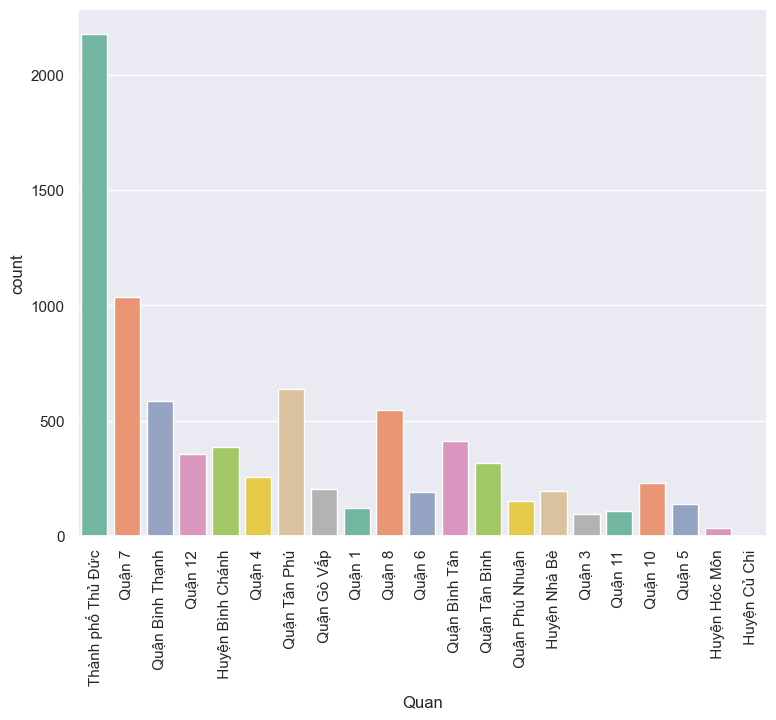

In [250]:
plt.figure(figsize=(15, 20))
plt.subplot(3, 2, 1)
ax1 = sns.countplot(x=BigDS_new_df['Quan'], palette="Set2")
ax1.set_xticklabels(BigDS_new_df['Quan'].unique(), rotation=90)
plt.tight_layout()
plt.show()

=> chuyển qua file clean để làm sạch những nhà có S <

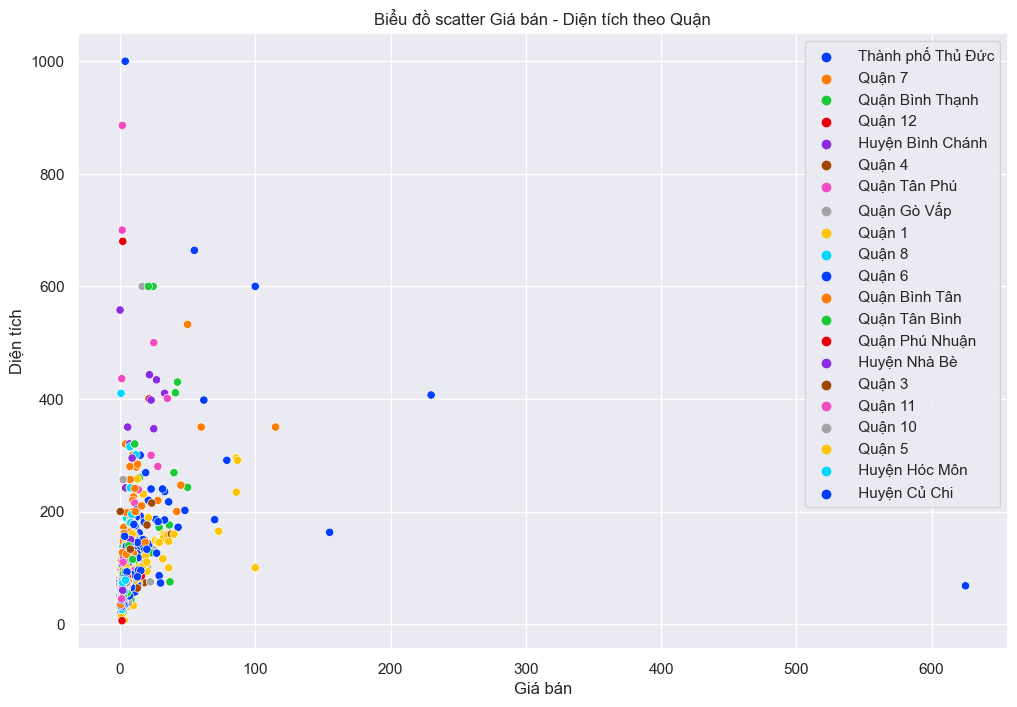

In [251]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='GiaBan', y='DienTich(m2)', hue='Quan', data=BigDS_new_df, palette='bright')
plt.xlabel('Giá bán')
plt.ylabel('Diện tích')
plt.title('Biểu đồ scatter Giá bán - Diện tích theo Quận')
plt.legend()
plt.grid(True)
plt.show()

In [252]:
BigDS_new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8168 entries, 0 to 8167
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Quan              8168 non-null   object 
 1   DienTich(m2)      8168 non-null   float64
 2   GiaBan            8168 non-null   float64
 3   PhongNgu          8168 non-null   float64
 4   PhongVeSinh       6860 non-null   float64
 5   TinhTrangBDS      8168 non-null   object 
 6   TinhTrangGiayTo   2346 non-null   object 
 7   TinhTrangNoiThat  1634 non-null   object 
 8   HuongBanCong      1288 non-null   object 
 9   HuongCua          1943 non-null   object 
dtypes: float64(4), object(6)
memory usage: 638.2+ KB


In [253]:
BigDS_new_df["TinhTrangGiayTo"].unique()

array([nan, 'Đã có sổ', 'Giấy tờ khác', 'Đang chờ sổ'], dtype=object)

In [254]:
BigDS_new_df["TinhTrangBDS"].unique()

array(['Đã bàn giao', 'Chưa bàn giao'], dtype=object)

In [255]:
BigDS_new_df["TinhTrangGiayTo"].unique()

array([nan, 'Đã có sổ', 'Giấy tờ khác', 'Đang chờ sổ'], dtype=object)

In [256]:
BigDS_new_df["Quan"].unique()

array([' Thành phố Thủ Đức', ' Quận 7', ' Quận Bình Thạnh', ' Quận 12',
       ' Huyện Bình Chánh', ' Quận 4', ' Quận Tân Phú', ' Quận Gò Vấp',
       ' Quận 1', ' Quận 8', ' Quận 6', ' Quận Bình Tân',
       ' Quận Tân Bình', ' Quận Phú Nhuận', ' Huyện Nhà Bè', ' Quận 3',
       ' Quận 11', ' Quận 10', ' Quận 5', ' Huyện Hóc Môn',
       ' Huyện Củ Chi'], dtype=object)

In [257]:
BigDS_new_df["TinhTrangNoiThat"].unique()

array(['Nội thất đầy đủ', nan, 'Nhà trống', 'Bàn giao thô',
       'Nội thất cao cấp'], dtype=object)

In [258]:
BigDS_new_df["HuongBanCong"].unique()

array([nan, 'Đông', 'Tây', 'Đông Nam', 'Đông Bắc', 'Nam', 'Tây Bắc',
       'Bắc', 'Tây Nam'], dtype=object)

In [259]:
BigDS_new_df["HuongCua"].unique()

array([nan, 'Tây', 'Bắc', 'Nam', 'Tây Bắc', 'Đông', 'Đông Nam', 'Tây Nam',
       'Đông Bắc'], dtype=object)

- Chuyển đổi dữ liệu sang dạng số và xử lý dữ liệu trống


In [260]:
def Convert_TinhTrangBDS(BigDS_new_df):
    encoder = ce.OrdinalEncoder(cols=['TinhTrangBDS'])
    BigDS_new_df = encoder.fit_transform(BigDS_new_df)
    BigDS_new_df['TinhTrangBDS'] = BigDS_new_df['TinhTrangBDS'].astype(float)
    return BigDS_new_df

- Xử lý cột 'PhongVeSinh'


In [261]:
# Hàm xử lí giá trị trống    
def Impute_missing_PhongVeSinh(BigDS_new_df, impute_method, BigDS_train = None):
    if BigDS_train is None:
        if impute_method == 'mean':
            BigDS_new_df['PhongVeSinh'].fillna(BigDS_new_df['PhongVeSinh'].mean(), inplace=True)
        elif impute_method == 'mode':
            BigDS_new_df['PhongVeSinh'].fillna(BigDS_new_df['PhongVeSinh'].mode()[0], inplace=True)
        elif impute_method == 'median':
            BigDS_new_df['PhongVeSinh'].fillna(BigDS_new_df['PhongVeSinh'].median(), inplace=True) 
    else:
        if impute_method == 'mean':
            BigDS_new_df['PhongVeSinh'].fillna(BigDS_train['PhongVeSinh'].mean(), inplace=True)
        elif impute_method == 'mode':
            BigDS_new_df['PhongVeSinh'].fillna(BigDS_train['PhongVeSinh'].mode()[0], inplace=True)
        elif impute_method == 'median':
            BigDS_new_df['PhongVeSinh'].fillna(BigDS_train['PhongVeSinh'].median(), inplace=True) 
    return BigDS_new_df

- Xử lý cột 'TinhTrangGiayTo'


In [262]:
def Convert_TinhTrangGiayTo(BigDS_new_df):
    encoder = ce.OrdinalEncoder(cols=['TinhTrangGiayTo'])
    BigDS_new_df = encoder.fit_transform(BigDS_new_df)
    BigDS_new_df['TinhTrangGiayTo'] = BigDS_new_df['TinhTrangGiayTo'].astype(float)
    return BigDS_new_df

In [263]:
def Impute_missing_TinhTrangGiayTo(BigDS_new_df, impute_method, BigDS_train=None):
    
    BigDS_new_df = Convert_TinhTrangGiayTo(BigDS_new_df)

    if BigDS_train is None:
        if impute_method == 'mean':
            BigDS_new_df['TinhTrangGiayTo'].fillna(BigDS_new_df['TinhTrangGiayTo'].mean(), inplace=True)
        elif impute_method == 'mode':
            BigDS_new_df['TinhTrangGiayTo'].fillna(BigDS_new_df['TinhTrangGiayTo'].mode()[0], inplace=True)
        elif impute_method == 'median':
            BigDS_new_df['TinhTrangGiayTo'].fillna(BigDS_new_df['TinhTrangGiayTo'].median(), inplace=True)
        
    else:
        if impute_method == 'mean':
            BigDS_new_df['TinhTrangGiayTo'].fillna(BigDS_train['TinhTrangGiayTo'].mean(), inplace=True)
        elif impute_method == 'mode':
            BigDS_new_df['TinhTrangGiayTo'].fillna(BigDS_train['TinhTrangGiayTo'].mode()[0], inplace=True)
        elif impute_method == 'median':
            BigDS_new_df['TinhTrangGiayTo'].fillna(BigDS_train['TinhTrangGiayTo'].median(), inplace=True) 

    return BigDS_new_df

- Xử lý cột 'TinhTrangNoiThat'


In [264]:
def Convert_TinhTrangNoiThat(BigDS_new_df):
    encoder = ce.OrdinalEncoder(cols=['TinhTrangNoiThat'])
    BigDS_new_df = encoder.fit_transform(BigDS_new_df)
    
    BigDS_new_df['TinhTrangNoiThat'] = BigDS_new_df['TinhTrangNoiThat'].astype(float)
    return BigDS_new_df

In [265]:
def Impute_missing_TinhTrangNoiThat(BigDS_new_df, impute_method, BigDS_train=None):
    
    BigDS_new_df = Convert_TinhTrangNoiThat(BigDS_new_df)

    if BigDS_train is None:
        if impute_method == 'mean':
            BigDS_new_df['TinhTrangNoiThat'].fillna(BigDS_new_df['TinhTrangNoiThat'].mean(), inplace=True)
        elif impute_method == 'mode':
            BigDS_new_df['TinhTrangNoiThat'].fillna(BigDS_new_df['TinhTrangNoiThat'].mode()[0], inplace=True)
        elif impute_method == 'median':
            BigDS_new_df['TinhTrangNoiThat'].fillna(BigDS_new_df['TinhTrangNoiThat'].median(), inplace=True)
        
    else:
        if impute_method == 'mean':
            BigDS_new_df['TinhTrangNoiThat'].fillna(BigDS_train['TinhTrangNoiThat'].mean(), inplace=True)
        elif impute_method == 'mode':
            BigDS_new_df['TinhTrangNoiThat'].fillna(BigDS_train['TinhTrangNoiThat'].mode()[0], inplace=True)
        elif impute_method == 'median':
            BigDS_new_df['TinhTrangNoiThat'].fillna(BigDS_train['TinhTrangNoiThat'].median(), inplace=True) 

    return BigDS_new_df

- Xử lí cột 'HuongBanCong'


In [266]:
def Convert_HuongBanCong(BigDS_new_df):
    encoder = ce.OrdinalEncoder(cols=['HuongBanCong'])
    BigDS_new_df = encoder.fit_transform(BigDS_new_df)
    BigDS_new_df['HuongBanCong'] = BigDS_new_df['HuongBanCong'].astype(float)
    return BigDS_new_df

In [267]:
def Impute_missing_HuongBanCong(BigDS_new_df, impute_method, BigDS_train=None):
    
    BigDS_new_df = Convert_HuongBanCong(BigDS_new_df)

    if BigDS_train is None:
        if impute_method == 'mean':
            BigDS_new_df['HuongBanCong'].fillna(BigDS_new_df['HuongBanCong'].mean(), inplace=True)
        elif impute_method == 'mode':
            BigDS_new_df['HuongBanCong'].fillna(BigDS_new_df['HuongBanCong'].mode()[0], inplace=True)
        elif impute_method == 'median':
            BigDS_new_df['HuongBanCong'].fillna(BigDS_new_df['HuongBanCong'].median(), inplace=True)
        
    else:
        if impute_method == 'mean':
            BigDS_new_df['HuongBanCong'].fillna(BigDS_train['HuongBanCong'].mean(), inplace=True)
        elif impute_method == 'mode':
            BigDS_new_df['HuongBanCong'].fillna(BigDS_train['HuongBanCong'].mode()[0], inplace=True)
        elif impute_method == 'median':
            BigDS_new_df['HuongBanCong'].fillna(BigDS_train['HuongBanCong'].median(), inplace=True) 

    return BigDS_new_df

- Xử lí trên cột 'HuongCua'


In [268]:
def Convert_HuongCua(BigDS_new_df):
    encoder = ce.OrdinalEncoder(cols=['HuongCua'])
    BigDS_new_df = encoder.fit_transform(BigDS_new_df)
    BigDS_new_df['HuongCua'] = BigDS_new_df['HuongCua'].astype(float)
    return BigDS_new_df

In [269]:
def Impute_missing_HuongCua(BigDS_new_df, impute_method, BigDS_train=None):
    
    BigDS_new_df = Convert_HuongCua(BigDS_new_df)

    if BigDS_train is None:
        if impute_method == 'mean':
            BigDS_new_df['HuongCua'].fillna(BigDS_new_df['HuongCua'].mean(), inplace=True)
        elif impute_method == 'mode':
            BigDS_new_df['HuongCua'].fillna(BigDS_new_df['HuongCua'].mode()[0], inplace=True)
        elif impute_method == 'median':
            BigDS_new_df['HuongCua'].fillna(BigDS_new_df['HuongCua'].median(), inplace=True)
        
    else:
        if impute_method == 'mean':
            BigDS_new_df['HuongCua'].fillna(BigDS_train['HuongCua'].mean(), inplace=True)
        elif impute_method == 'mode':
            BigDS_new_df['HuongCua'].fillna(BigDS_train['HuongCua'].mode()[0], inplace=True)
        elif impute_method == 'median':
            BigDS_new_df['HuongCua'].fillna(BigDS_train['HuongCua'].median(), inplace=True) 

    return BigDS_new_df

- Xử lí dữ liệu trên cột 'Quan'


In [270]:
def Convert_Quan(BigDS_new_df):
    encoder = ce.OrdinalEncoder(cols=['Quan'])
    BigDS_new_df = encoder.fit_transform(BigDS_new_df)
    BigDS_new_df['Quan'] = BigDS_new_df['Quan'].astype(float)
    return BigDS_new_df

In [271]:
def Impute_missing_Quan(BigDS_new_df, impute_method, BigDS_train=None):
    
    BigDS_new_df = Convert_Quan(BigDS_new_df)

    if BigDS_train is None:
        if impute_method == 'mean':
            BigDS_new_df['Quan'].fillna(BigDS_new_df['Quan'].mean(), inplace=True)
        elif impute_method == 'mode':
            BigDS_new_df['Quan'].fillna(BigDS_new_df['Quan'].mode()[0], inplace=True)
        elif impute_method == 'median':
            BigDS_new_df['Quan'].fillna(BigDS_new_df['Quan'].median(), inplace=True)
        
    else:
        if impute_method == 'mean':
            BigDS_new_df['Quan'].fillna(BigDS_train['Quan'].mean(), inplace=True)
        elif impute_method == 'mode':
            BigDS_new_df['Quan'].fillna(BigDS_train['Quan'].mode()[0], inplace=True)
        elif impute_method == 'median':
            BigDS_new_df['Quan'].fillna(BigDS_train['Quan'].median(), inplace=True) 

    return BigDS_new_df

In [272]:
BigDS_new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8168 entries, 0 to 8167
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Quan              8168 non-null   object 
 1   DienTich(m2)      8168 non-null   float64
 2   GiaBan            8168 non-null   float64
 3   PhongNgu          8168 non-null   float64
 4   PhongVeSinh       6860 non-null   float64
 5   TinhTrangBDS      8168 non-null   object 
 6   TinhTrangGiayTo   2346 non-null   object 
 7   TinhTrangNoiThat  1634 non-null   object 
 8   HuongBanCong      1288 non-null   object 
 9   HuongCua          1943 non-null   object 
dtypes: float64(4), object(6)
memory usage: 638.2+ KB


In [273]:
X_BigDS = BigDS_new_df.drop(columns=['GiaBan'])
y_BigDS = np.log(BigDS_new_df['GiaBan'])
X_train_b,X_test_b,y_train_b,y_test_b = train_test_split(X_BigDS,y_BigDS,test_size=0.4,random_state=20)
X_test_b, X_val_b, y_test_b, y_val_b = train_test_split(X_test_b, y_test_b, test_size=0.5, random_state=20)

- Xử lí trên cột 'PhongVeSinh'


In [274]:
X_train_b = Impute_missing_PhongVeSinh(X_train_b,'median')
X_test_b = Impute_missing_PhongVeSinh(X_test_b,'median',X_train_b)
X_val_b = Impute_missing_PhongVeSinh(X_val_b,'median',X_train_b)

- Xử lí trên cột 'TinhTrangGiayTo'


In [275]:
X_train_b = Impute_missing_TinhTrangGiayTo(X_train_b,'median')
X_test_b = Impute_missing_TinhTrangGiayTo(X_test_b,'median',X_train_b)
X_val_b = Impute_missing_TinhTrangGiayTo(X_val_b,'median',X_train_b)

- Xử lí trên cột 'TinhTrangNoiThat'


In [276]:
X_train_b = Impute_missing_TinhTrangNoiThat(X_train_b,'median')
X_test_b = Impute_missing_TinhTrangNoiThat(X_test_b,'median',X_train_b)
X_val_b = Impute_missing_TinhTrangNoiThat(X_val_b,'median',X_train_b)

- Xử lí trên cột 'HuongBanCong'


In [277]:
X_train_b = Impute_missing_HuongBanCong(X_train_b,'median')
X_test_b = Impute_missing_HuongBanCong(X_test_b,'median',X_train_b)
X_val_b = Impute_missing_HuongBanCong(X_val_b,'median',X_train_b)

- Xử lí trên cột 'HuongCua'


In [278]:
X_train_b = Impute_missing_HuongCua(X_train_b,'median')
X_test_b = Impute_missing_HuongCua(X_test_b,'median',X_train_b)
X_val_b = Impute_missing_HuongCua(X_val_b,'median',X_train_b)

- Xử lí trên cột 'Quan'


In [279]:
X_train_b = Impute_missing_Quan(X_train_b,'median')
X_test_b = Impute_missing_Quan(X_test_b,'median',X_train_b)
X_val_b = Impute_missing_Quan(X_val_b,'median',X_train_b)

- Xử lí cột 'TinhTrangBDS'


In [280]:
X_train_b = Convert_TinhTrangBDS(X_train_b)
X_test_b = Convert_TinhTrangBDS(X_test_b)
X_val_b = Convert_TinhTrangBDS(X_val_b)


In [281]:
X_train_b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4900 entries, 5707 to 7523
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Quan              4900 non-null   float64
 1   DienTich(m2)      4900 non-null   float64
 2   PhongNgu          4900 non-null   float64
 3   PhongVeSinh       4900 non-null   float64
 4   TinhTrangBDS      4900 non-null   float64
 5   TinhTrangGiayTo   4900 non-null   float64
 6   TinhTrangNoiThat  4900 non-null   float64
 7   HuongBanCong      4900 non-null   float64
 8   HuongCua          4900 non-null   float64
dtypes: float64(9)
memory usage: 382.8 KB


In [282]:
X_test_b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1634 entries, 7582 to 2762
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Quan              1634 non-null   float64
 1   DienTich(m2)      1634 non-null   float64
 2   PhongNgu          1634 non-null   float64
 3   PhongVeSinh       1634 non-null   float64
 4   TinhTrangBDS      1634 non-null   float64
 5   TinhTrangGiayTo   1634 non-null   float64
 6   TinhTrangNoiThat  1634 non-null   float64
 7   HuongBanCong      1634 non-null   float64
 8   HuongCua          1634 non-null   float64
dtypes: float64(9)
memory usage: 127.7 KB


In [283]:
X_val_b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1634 entries, 3048 to 7355
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Quan              1634 non-null   float64
 1   DienTich(m2)      1634 non-null   float64
 2   PhongNgu          1634 non-null   float64
 3   PhongVeSinh       1634 non-null   float64
 4   TinhTrangBDS      1634 non-null   float64
 5   TinhTrangGiayTo   1634 non-null   float64
 6   TinhTrangNoiThat  1634 non-null   float64
 7   HuongBanCong      1634 non-null   float64
 8   HuongCua          1634 non-null   float64
dtypes: float64(9)
memory usage: 127.7 KB


In [284]:
train_data = X_train_b.join(y_train_b)

array([[<AxesSubplot:title={'center':'Quan'}>,
        <AxesSubplot:title={'center':'DienTich(m2)'}>,
        <AxesSubplot:title={'center':'PhongNgu'}>],
       [<AxesSubplot:title={'center':'PhongVeSinh'}>,
        <AxesSubplot:title={'center':'TinhTrangBDS'}>,
        <AxesSubplot:title={'center':'TinhTrangGiayTo'}>],
       [<AxesSubplot:title={'center':'TinhTrangNoiThat'}>,
        <AxesSubplot:title={'center':'HuongBanCong'}>,
        <AxesSubplot:title={'center':'HuongCua'}>]], dtype=object)

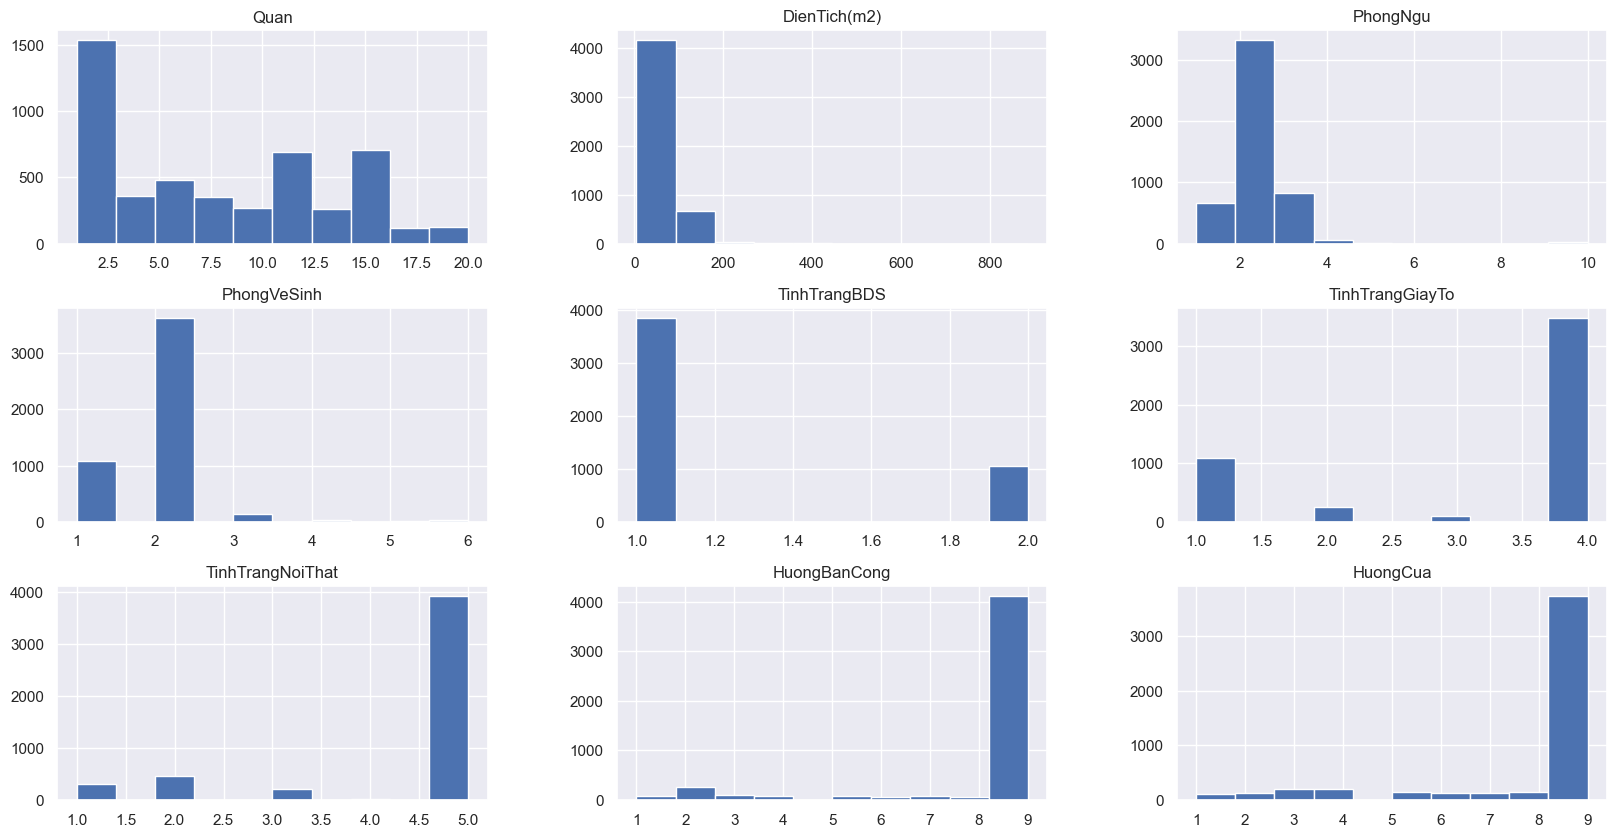

In [285]:
X_train_b.hist(figsize=(20,10))

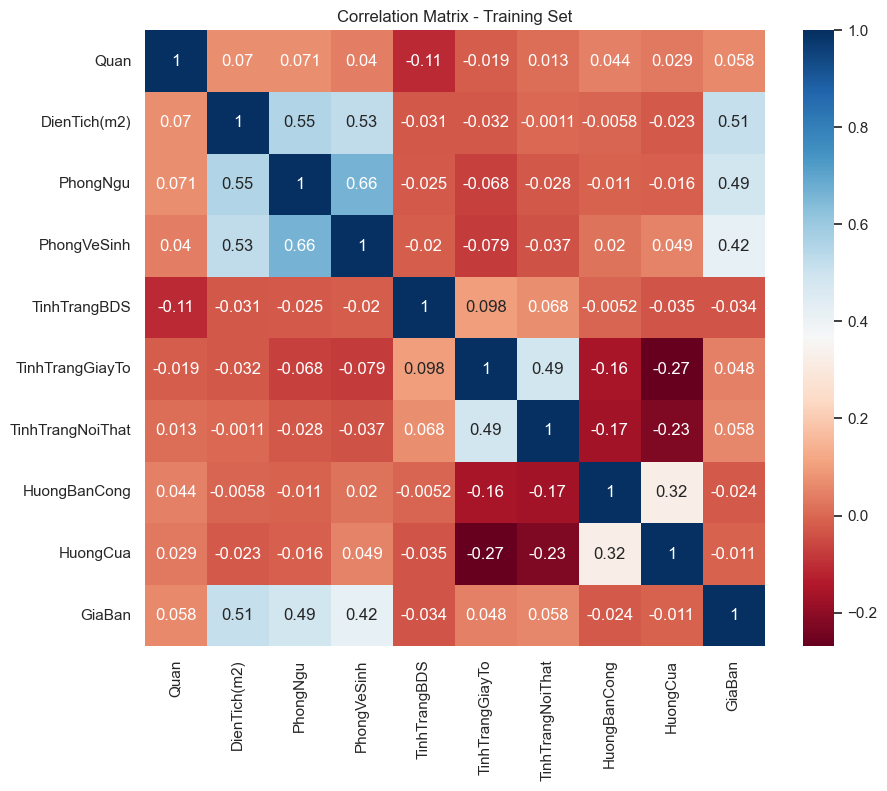

In [286]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = X_train_b.copy()
correlation_matrix['GiaBan'] = y_train_b
correlation_matrix = correlation_matrix.corr()

plt.figure(figsize=(10, 8))  # Đặt kích thước của figure
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu')  # Vẽ heatmap với ma trận tương quan
plt.title('Correlation Matrix - Training Set')  # Đặt tiêu đề cho biểu đồ
plt.show()  # Hiển thị biểu đồ


In [287]:
k_best = SelectKBest(f_regression, k=5)
X_train_belected = k_best.fit_transform(X_train_b, y_train_b)
selected_features = X_train_b.columns[k_best.get_support()]
X_val_belected = k_best.transform(X_val_b)
X_test_belected = k_best.transform(X_test_b)
print("Selected Features:")
print(selected_features)


Selected Features:
Index(['Quan', 'DienTich(m2)', 'PhongNgu', 'PhongVeSinh', 'TinhTrangNoiThat'], dtype='object')


### Lựa chọn đặc trưng

In [288]:
X_train_b = X_train_b[['DienTich(m2)', 'PhongNgu', 'PhongVeSinh','TinhTrangBDS','TinhTrangGiayTo']]
X_val_b = X_val_b[['DienTich(m2)', 'PhongNgu', 'PhongVeSinh','TinhTrangBDS','TinhTrangGiayTo']]
X_test_b = X_test_b[['DienTich(m2)', 'PhongNgu', 'PhongVeSinh','TinhTrangBDS','TinhTrangGiayTo']]

### Xem tác động các tính năng đến giá bán

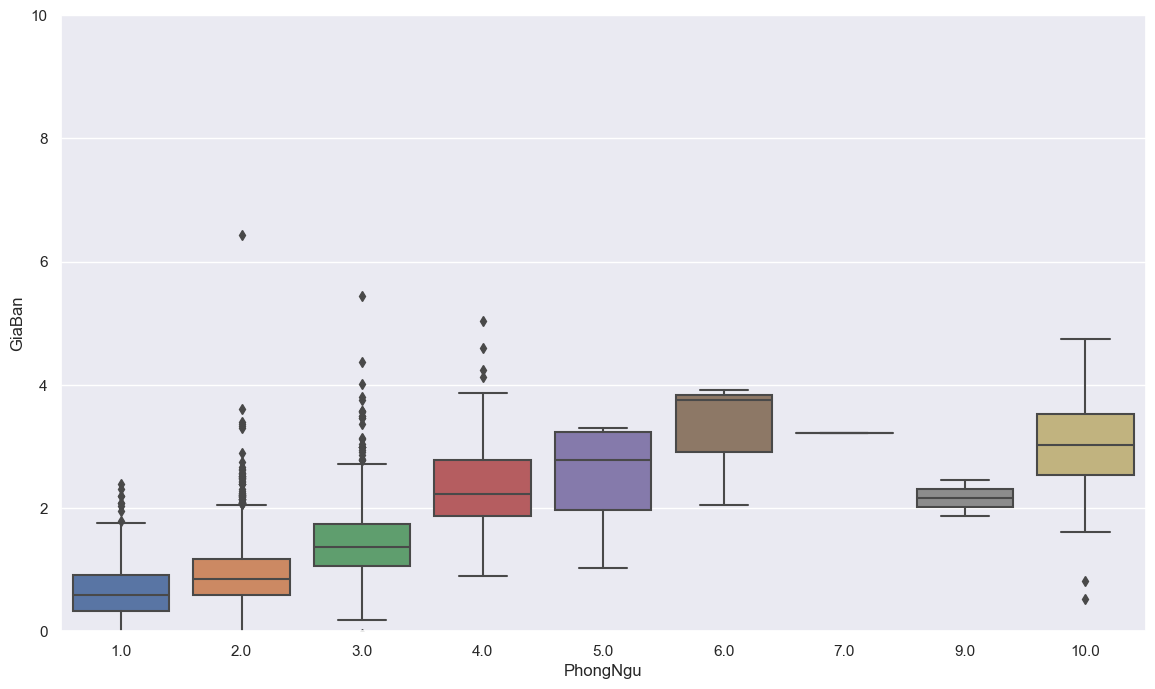

In [289]:
var = 'PhongNgu'
data = pd.concat([y_train_b, X_train_b['PhongNgu']], axis=1)
plt.figure(figsize=(14, 8))
sns.boxplot(x=var, y=y_train_b, data=data)
plt.ylim(0, 10)  # Giới hạn trục y từ 0 đến 70
plt.show()


In [290]:
norm_upper_limit_train = X_train_b['PhongNgu'].mean() + 3 * X_train_b['PhongNgu'].std()
norm_lower_limit_train = X_train_b['PhongNgu'].mean() - 3 * X_train_b['PhongNgu'].std()
norm_upper_limit_test = X_test_b['PhongNgu'].mean() + 3 * X_test_b['PhongNgu'].std()
norm_lower_limit_test = X_test_b['PhongNgu'].mean() - 3 * X_test_b['PhongNgu'].std()
norm_upper_limit_val = X_val_b['PhongNgu'].mean() + 3 * X_val_b['PhongNgu'].std()
norm_lower_limit_val = X_val_b['PhongNgu'].mean() - 3 * X_val_b['PhongNgu'].std()

In [291]:
df_normal_new_train = X_train_b[(X_train_b['PhongNgu'] > norm_lower_limit_train) & ( X_train_b['PhongNgu'] < norm_upper_limit_train)]
df_normal_new_test = X_test_b[(X_test_b['PhongNgu'] > norm_lower_limit_test) & ( X_test_b['PhongNgu'] < norm_upper_limit_test)]
df_normal_new_val = X_val_b[(X_val_b['PhongNgu'] > norm_lower_limit_val) & ( X_val_b['PhongNgu'] < norm_upper_limit_val)]

In [292]:
print("Before Outlier Size:", X_train_b.shape[0])
print("After Outlier Size:", df_normal_new_train.shape[0])

Before Outlier Size: 4900
After Outlier Size: 4861


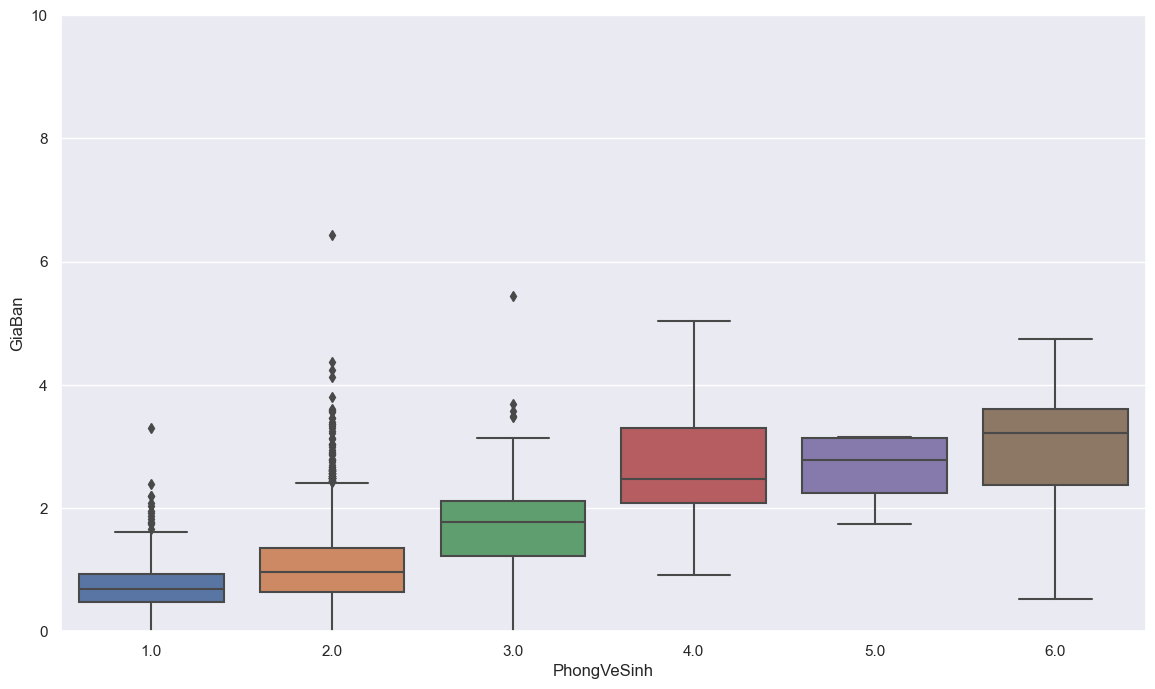

In [293]:
var = 'PhongVeSinh'
data = pd.concat([y_train_b, X_train_b['PhongVeSinh']], axis=1)
plt.figure(figsize=(14, 8))
sns.boxplot(x=var, y=y_train_b, data=data)
plt.ylim(0, 10)  # Giới hạn trục y từ 0 đến 70
plt.show()

In [294]:
norm_upper_limit_train = X_train_b['PhongVeSinh'].mean() + 3 * X_train_b['PhongVeSinh'].std()
norm_lower_limit_train = X_train_b['PhongVeSinh'].mean() - 3 * X_train_b['PhongVeSinh'].std()
norm_upper_limit_test = X_test_b['PhongVeSinh'].mean() + 3 * X_test_b['PhongVeSinh'].std()
norm_lower_limit_test = X_test_b['PhongVeSinh'].mean() - 3 * X_test_b['PhongVeSinh'].std()
norm_upper_limit_val = X_val_b['PhongVeSinh'].mean() + 3 * X_val_b['PhongVeSinh'].std()
norm_lower_limit_val = X_val_b['PhongVeSinh'].mean() - 3 * X_val_b['PhongVeSinh'].std()

In [295]:
df_normal_new_train = X_train_b[(X_train_b['PhongVeSinh'] > norm_lower_limit_train) & ( X_train_b['PhongVeSinh'] < norm_upper_limit_train)]
df_normal_new_test = X_test_b[(X_test_b['PhongVeSinh'] > norm_lower_limit_test) & ( X_test_b['PhongVeSinh'] < norm_upper_limit_test)]
df_normal_new_val = X_val_b[(X_val_b['PhongVeSinh'] > norm_lower_limit_val) & ( X_val_b['PhongVeSinh'] < norm_upper_limit_val)]

In [296]:
print("Before Outlier Size:", X_train_b.shape[0])
print("After Outlier Size:", df_normal_new_train.shape[0])

Before Outlier Size: 4900
After Outlier Size: 4847


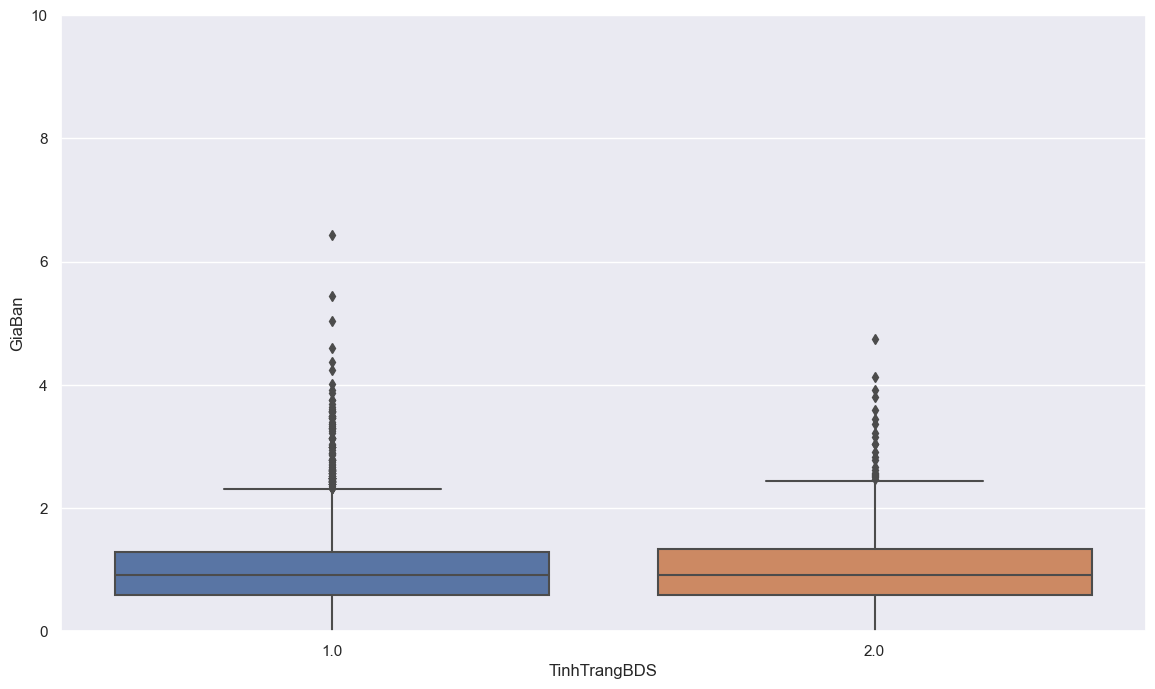

In [297]:
var = 'TinhTrangBDS'
data = pd.concat([y_train_b, X_train_b['TinhTrangBDS']], axis=1)
plt.figure(figsize=(14, 8))
sns.boxplot(x=var, y=y_train_b, data=data)
plt.ylim(0, 10)  # Giới hạn trục y từ 0 đến 70

plt.show()


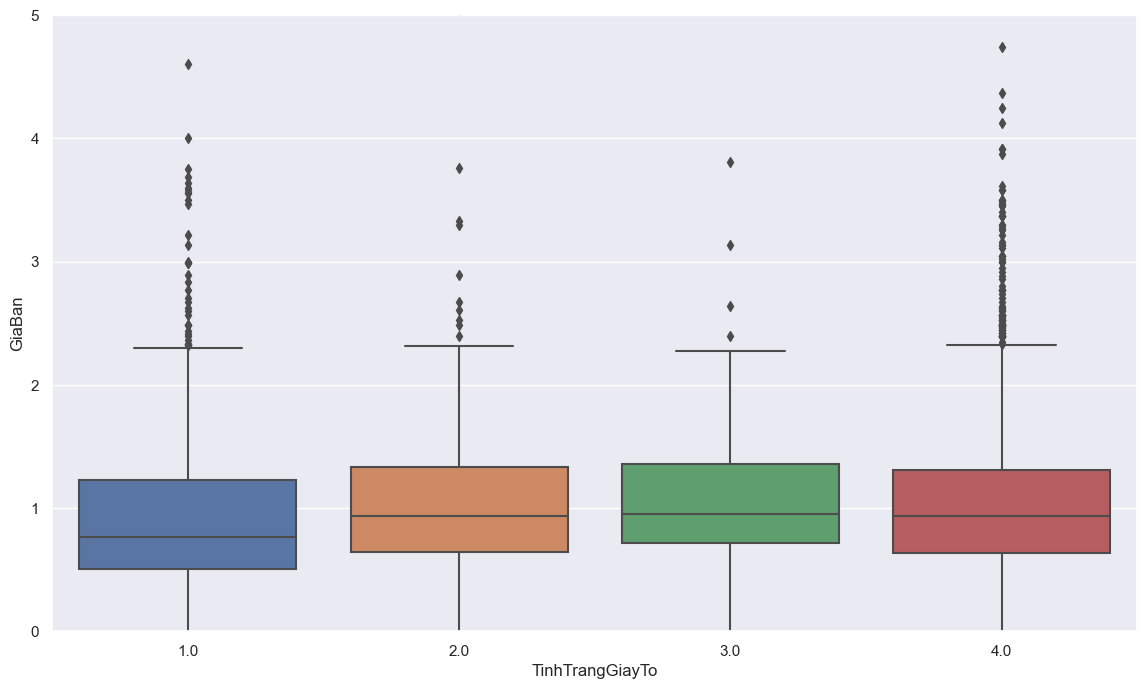

In [298]:
var = 'TinhTrangGiayTo'
data = pd.concat([y_train_b, X_train_b['TinhTrangGiayTo']], axis=1)
plt.figure(figsize=(14, 8))
sns.boxplot(x=var, y=y_train_b, data=data)
plt.ylim(0, 5)  # Giới hạn trục y từ 0 đến 70
plt.show()

### Xử lý ngoại lệ cột 'DienTich(m2)'

In [299]:
norm_upper_limit_train = X_train_b['DienTich(m2)'].mean() + 3 * X_train_b['DienTich(m2)'].std()
norm_lower_limit_train = X_train_b['DienTich(m2)'].mean() - 3 * X_train_b['DienTich(m2)'].std()

In [300]:
norm_upper_limit_test = X_test_b['DienTich(m2)'].mean() + 3 * X_test_b['DienTich(m2)'].std()
norm_lower_limit_test = X_test_b['DienTich(m2)'].mean() - 3 * X_test_b['DienTich(m2)'].std()

In [301]:
norm_upper_limit_val = X_val_b['DienTich(m2)'].mean() + 3 * X_val_b['DienTich(m2)'].std()
norm_lower_limit_val = X_val_b['DienTich(m2)'].mean() - 3 * X_val_b['DienTich(m2)'].std()

In [302]:
df_normal_new_train = X_train_b[(X_train_b['DienTich(m2)'] > norm_lower_limit_train) & ( X_train_b['DienTich(m2)'] < norm_upper_limit_train)]

In [303]:
df_normal_new_test = X_test_b[(X_test_b['DienTich(m2)'] > norm_lower_limit_test) & ( X_test_b['DienTich(m2)'] < norm_upper_limit_test)]

In [304]:
df_normal_new_val = X_val_b[(X_val_b['DienTich(m2)'] > norm_lower_limit_val) & ( X_val_b['DienTich(m2)'] < norm_upper_limit_val)]

In [305]:
print("Before Triming Size:", X_train_b.shape[0])
print("After Triming Size:", df_normal_new_train.shape[0])

Before Triming Size: 4900
After Triming Size: 4849


<AxesSubplot:>

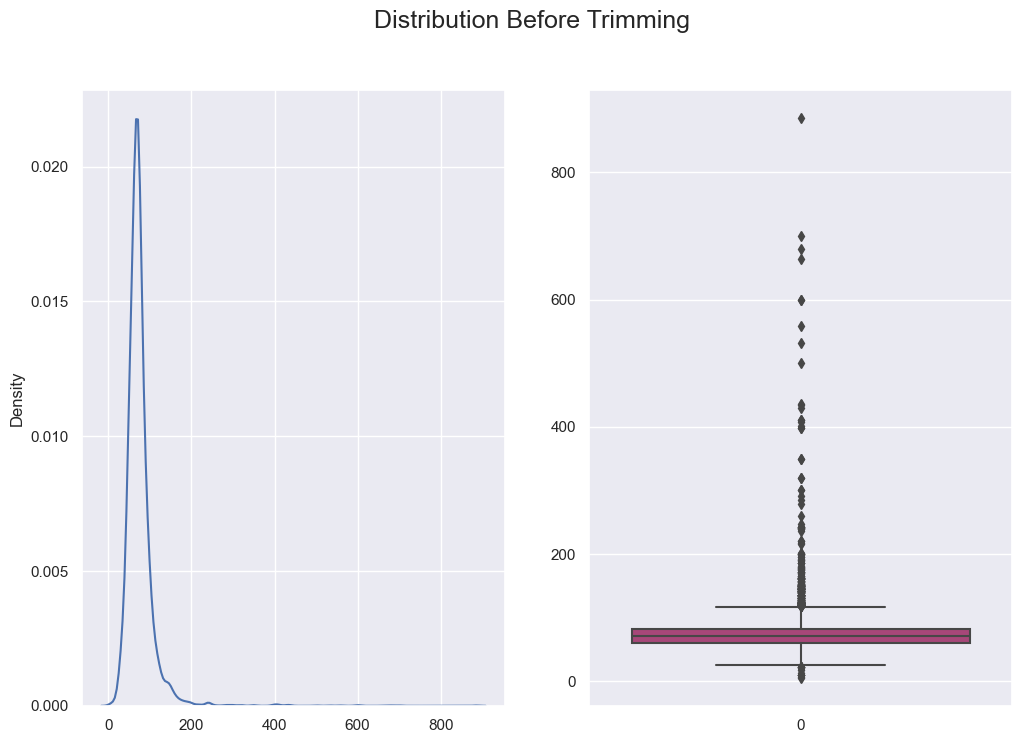

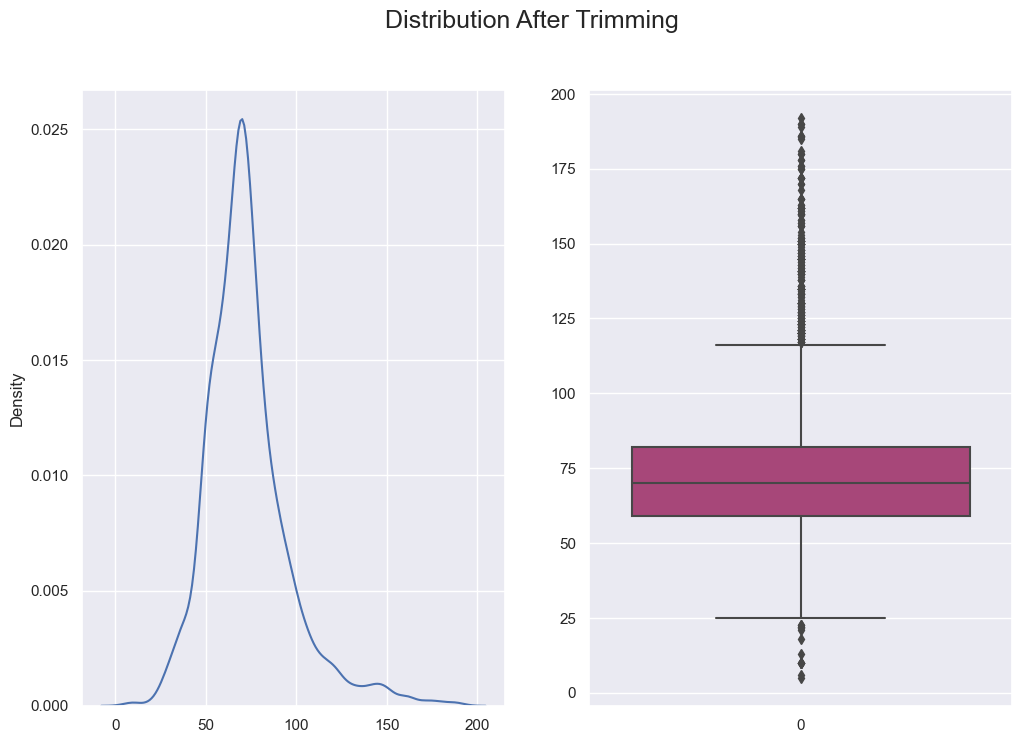

In [306]:
# Before Trimming
plt.figure(figsize = (12, 8))
plt.suptitle("Distribution Before Trimming", fontsize = 18)
plt.subplot(1, 2, 1)
sns.kdeplot(data = X_train_b['DienTich(m2)'].values)
plt.subplot(1, 2, 2)
sns.boxplot(data = X_train_b['DienTich(m2)'].values, palette = "magma")

# After Trimming
plt.figure(figsize = (12, 8))
plt.suptitle("Distribution After Trimming", fontsize = 18)
plt.subplot(1, 2, 1)
sns.kdeplot(data = df_normal_new_train['DienTich(m2)'].values)
plt.subplot(1, 2, 2)
sns.boxplot(data = df_normal_new_train['DienTich(m2)'].values, palette = "magma")

In [307]:
def scaler_transform(X_train,X_test,X_val,scaler_type):
    if scaler_type == 'standard':
        scaler = StandardScaler()
    elif scaler_type == 'min_max':
        scaler = MinMaxScaler()
    elif scaler_type == 'robust':
        scaler = RobustScaler()
    elif scaler_type == 'maxabs':
        scaler = MaxAbsScaler()
    elif scaler_type == 'norma':
        scaler = Normalizer()
    elif scaler_type == 'quantil':
        scaler = QuantileTransformer(n_quantiles=620)
    elif scaler_type == 'powert':
        scaler = PowerTransformer()
    else:
        raise ValueError('Scaler not recognized')
    X_train_tranformed =  pd.DataFrame(scaler.fit_transform(X_train))
    X_test_tranformed  =  pd.DataFrame(scaler.transform(X_test))
    X_val_tranformed   =  pd.DataFrame(scaler.transform(X_val))
    return X_train_tranformed,X_test_tranformed,X_val_tranformed

In [308]:
X_train_b

,DienTich(m2),PhongNgu,PhongVeSinh,TinhTrangBDS,TinhTrangGiayTo
5707,71.0,2.0,2.0,1.0,4.0
443,50.0,2.0,2.0,1.0,4.0
5317,68.0,2.0,2.0,1.0,4.0
4544,104.0,3.0,2.0,1.0,1.0
4329,60.0,2.0,2.0,1.0,4.0
...,...,...,...,...,...
7068,74.8,2.0,1.0,1.0,4.0
7391,64.0,3.0,2.0,1.0,4.0
4367,118.0,3.0,2.0,1.0,1.0
2522,72.0,2.0,2.0,1.0,1.0


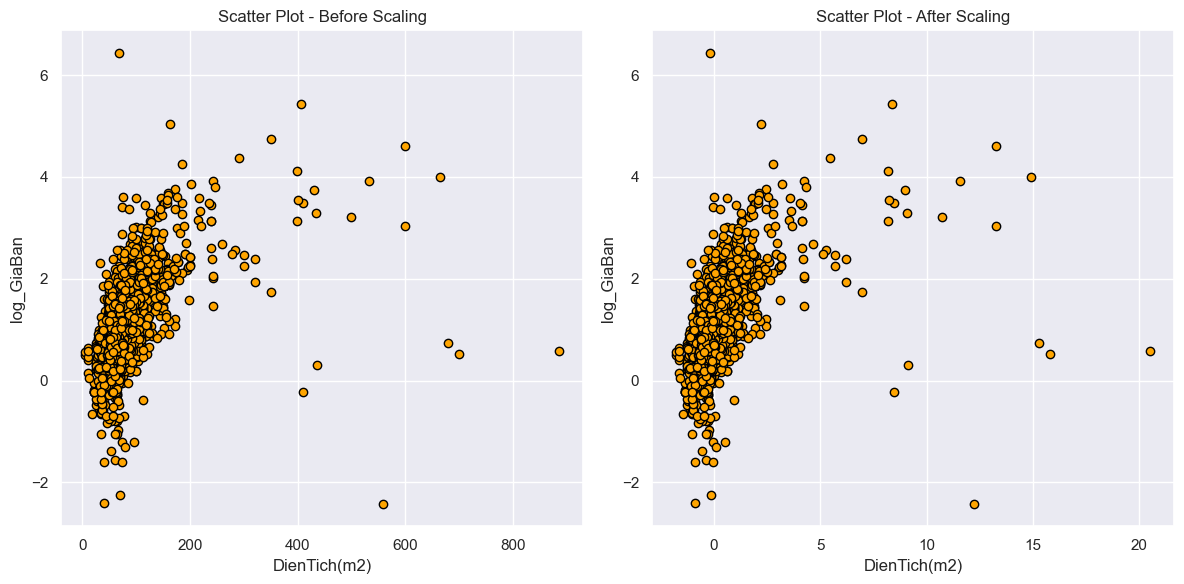

In [309]:
# Khởi tạo khung subplot
fig, axes = plt.subplots(1,2 ,figsize=(12, 6))



axes[0].scatter(X_train_b['DienTich(m2)'], y_train_b,facecolor='orange', edgecolor='black')
axes[0].set_xlabel('DienTich(m2)')
axes[0].set_ylabel('log_GiaBan')
axes[0].set_title('Scatter Plot - Before Scaling')


X_train_b, X_test_b, X_val_b = scaler_transform(X_train_b, X_test_b, X_val_b,'standard')
axes[1].scatter(X_train_b[0], y_train_b,facecolor='orange', edgecolor='black')
axes[1].set_xlabel('DienTich(m2)')
axes[1].set_ylabel('log_GiaBan')
axes[1].set_title('Scatter Plot - After Scaling')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


MAE và MSE là hai độ đo đánh giá mức độ chính xác của mô hình dự đoán so với giá trị thực tế.

MAE (Mean Absolute Error): là trung bình cộng của giá trị tuyệt đối của sai số giữa giá trị dự đoán và giá trị thực tế. MAE càng thấp thì mô hình dự đoán càng chính xác.

MSE (Mean Squared Error): là trung bình cộng của bình phương sai số giữa giá trị dự đoán và giá trị thực tế. MSE càng thấp thì mô hình dự đoán càng chính xác.

### Sử dụng mô hình LinearRegression

In [310]:
X_train_linear=X_train_b.copy()
X_test_linear=X_test_b.copy()
X_val_linear=X_val_b.copy()
y_train_linear=y_train_b.copy()
y_test_linear=y_test_b.copy()
y_val_linear=y_val_b.copy()

In [311]:
model = LinearRegression()
model.fit(X_train_linear, y_train_linear)

y_val_pred = model.predict(X_val_linear)
r2_val_before = r2_score(y_val_linear, y_val_pred).round(5)

y_test_pred = model.predict(X_test_linear)
r2_test_before = r2_score(y_test_linear, y_test_pred).round(5)

mae_val_before = mean_absolute_error(y_val_linear, y_val_pred).round(5)
mae_test_before = mean_absolute_error(y_test_linear, y_test_pred).round(5)

mse_val_before = mean_squared_error(y_val_linear,y_val_pred).round(5)
mse_test_before = mean_squared_error(y_test_linear,y_test_pred).round(5)

rmse_val_before = mean_squared_error(y_val_linear, y_val_pred, squared=False).round(5)
rmse_test_before = mean_squared_error(y_test_linear, y_test_pred, squared=False).round(5)

print("r2_score in validation:", r2_val_before)
print("r2_score in test:", r2_test_before)
print()
print("Test error (MAE) in validation: {}".format(mae_val_before))
print("Test error (MAE) in test: {}".format(mae_test_before))
print()
print("Test error (MSE) in validation: {}".format(mse_val_before))
print("Test error (MSE) in test: {}".format(mse_test_before))
print()
print("Test error (RMSE) in validation: {}".format(rmse_val_before))
print("Test error (RMSE) in test: {}".format(rmse_test_before))
print()
df = pd.DataFrame({'Giá trị nhãn đúng': y_val_linear, 'Nhãn dự đoán': y_val_pred, 'Chênh lệch': abs(y_val_linear - y_val_pred)})
print(df)

r2_score in validation: 0.25987
r2_score in test: 0.36774

Test error (MAE) in validation: 0.34935
Test error (MAE) in test: 0.35688

Test error (MSE) in validation: 0.24825
Test error (MSE) in test: 0.24317

Test error (RMSE) in validation: 0.49825
Test error (RMSE) in test: 0.49312

      Giá trị nhãn đúng  Nhãn dự đoán  Chênh lệch
3048           0.667829      0.699373    0.031543
3591           1.085189      1.040912    0.044277
4967           0.530628      0.855621    0.324993
303            0.963174      0.622456    0.340718
7099           0.832909      0.627767    0.205142
...                 ...           ...         ...
2022           1.420696      0.989859    0.430837
2530           0.506818      0.807820    0.301003
4235           1.481605      0.836862    0.644742
4141           0.470004      0.454555    0.015448
7355           0.641854      0.559362    0.082491

[1634 rows x 3 columns]


* Hiệu chỉnh mô hình 

In [312]:
model = LinearRegression()
param_grid = {
    'fit_intercept': [True, False] 
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=5)
grid_search.fit(X_train_linear, y_train_linear)
best_model = grid_search.best_estimator_
print("Best parameters: {}".format(grid_search.best_params_))

Best parameters: {'fit_intercept': True}


* Truyền tham số tốt nhất vào để chạy trên tập test

In [313]:
model = LinearRegression( fit_intercept = True)
model.fit(X_train_linear, y_train_linear)

y_val_pred = model.predict(X_val_linear)
r2_val_after = r2_score(y_val_linear, y_val_pred).round(5)

y_test_pred = model.predict(X_test_linear)
r2_test_after = r2_score(y_test_linear, y_test_pred).round(5)

mae_test_after = mean_absolute_error(y_test_linear,y_test_pred).round(5)
mae_val_after = mean_absolute_error(y_val_linear,y_val_pred).round(5)

mse_test_after = mean_squared_error(y_test_linear,y_test_pred).round(5)
mse_val_after = mean_squared_error(y_val_linear,y_val_pred).round(5)

rmse_test_after = mean_squared_error(y_test_linear,y_test_pred,squared = False).round(5)
rmse_val_after = mean_squared_error(y_val_linear,y_test_pred,squared = False).round(5)

print("R2-score in  validation:", r2_val_after)
print("R2-score in test:", r2_test_after)
print()
print("Test error (MAE) in test: {}".format(mae_test_after))
print("Test error (MAE) in validation: {}".format(mae_val_after))
print()
print("Test error (MSE) in test: {}".format(mse_test_after))
print("Test error (MSE) in validation: {}".format(mse_val_after))
print()
print("Test error (RMSE) in test: {}".format(rmse_test_after))
print("Test error (RMSE) in validation: {}".format(rmse_val_after))
print()
df = pd.DataFrame({'Giá trị nhãn đúng': y_test_linear, 'Nhãn dự đoán': y_test_pred,'Chênh lệch': abs(y_test_linear-y_test_pred)})
print(df)


R2-score in  validation: 0.25987
R2-score in test: 0.36774

Test error (MAE) in test: 0.35688
Test error (MAE) in validation: 0.34935

Test error (MSE) in test: 0.24317
Test error (MSE) in validation: 0.24825

Test error (RMSE) in test: 0.49312
Test error (RMSE) in validation: 0.67012

      Giá trị nhãn đúng  Nhãn dự đoán  Chênh lệch
7582           1.047319      1.160319    0.113000
1090           1.887070      1.333030    0.554040
6008           0.530628      0.664985    0.134356
3773           1.223775      0.957991    0.265784
6473           1.713798      1.638858    0.074940
...                 ...           ...         ...
668            0.500775      0.811538    0.310763
7535           0.614585      0.914045    0.299460
7124           0.693147      1.030290    0.337142
7474           0.765468      0.744012    0.021456
2762           0.974560      1.110600    0.136040

[1634 rows x 3 columns]


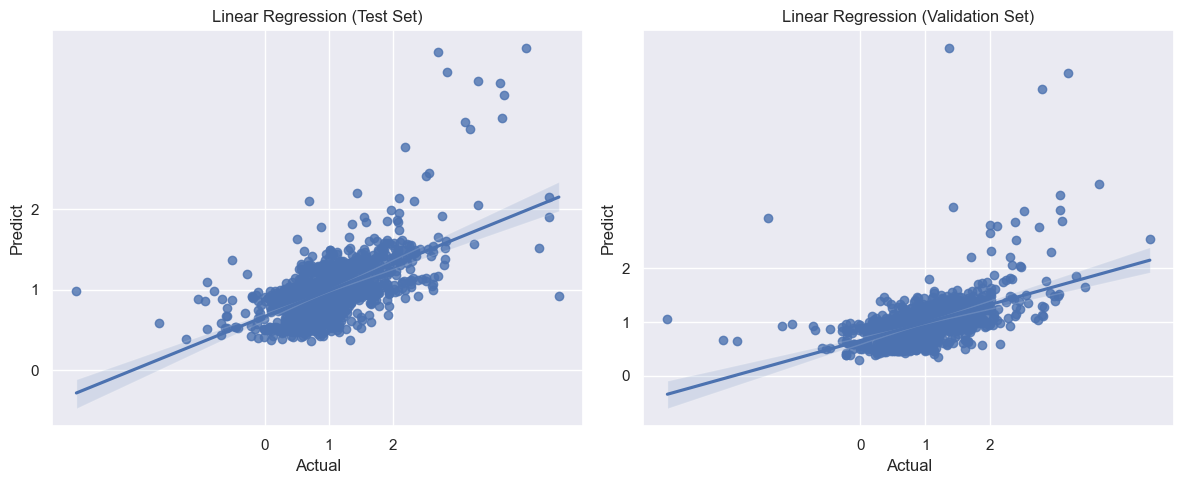

In [314]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ax1 = axes[0]
sns.regplot(x=y_test_linear, y=y_test_pred, ax=ax1)
ax1.set_title('Linear Regression (Test Set)')
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predict')
ax1.set_xticks(range(0, 3, 1))
ax1.set_yticks(range(0, 3, 1))
ax2 = axes[1]
sns.regplot(x=y_val_linear, y=y_val_pred, ax=ax2)
ax2.set_title('Linear Regression (Validation Set)')
ax2.set_xlabel('Actual')
ax2.set_ylabel('Predict')
ax2.set_xticks(range(0, 3, 1))
ax2.set_yticks(range(0, 3, 1))
plt.tight_layout()
plt.show()

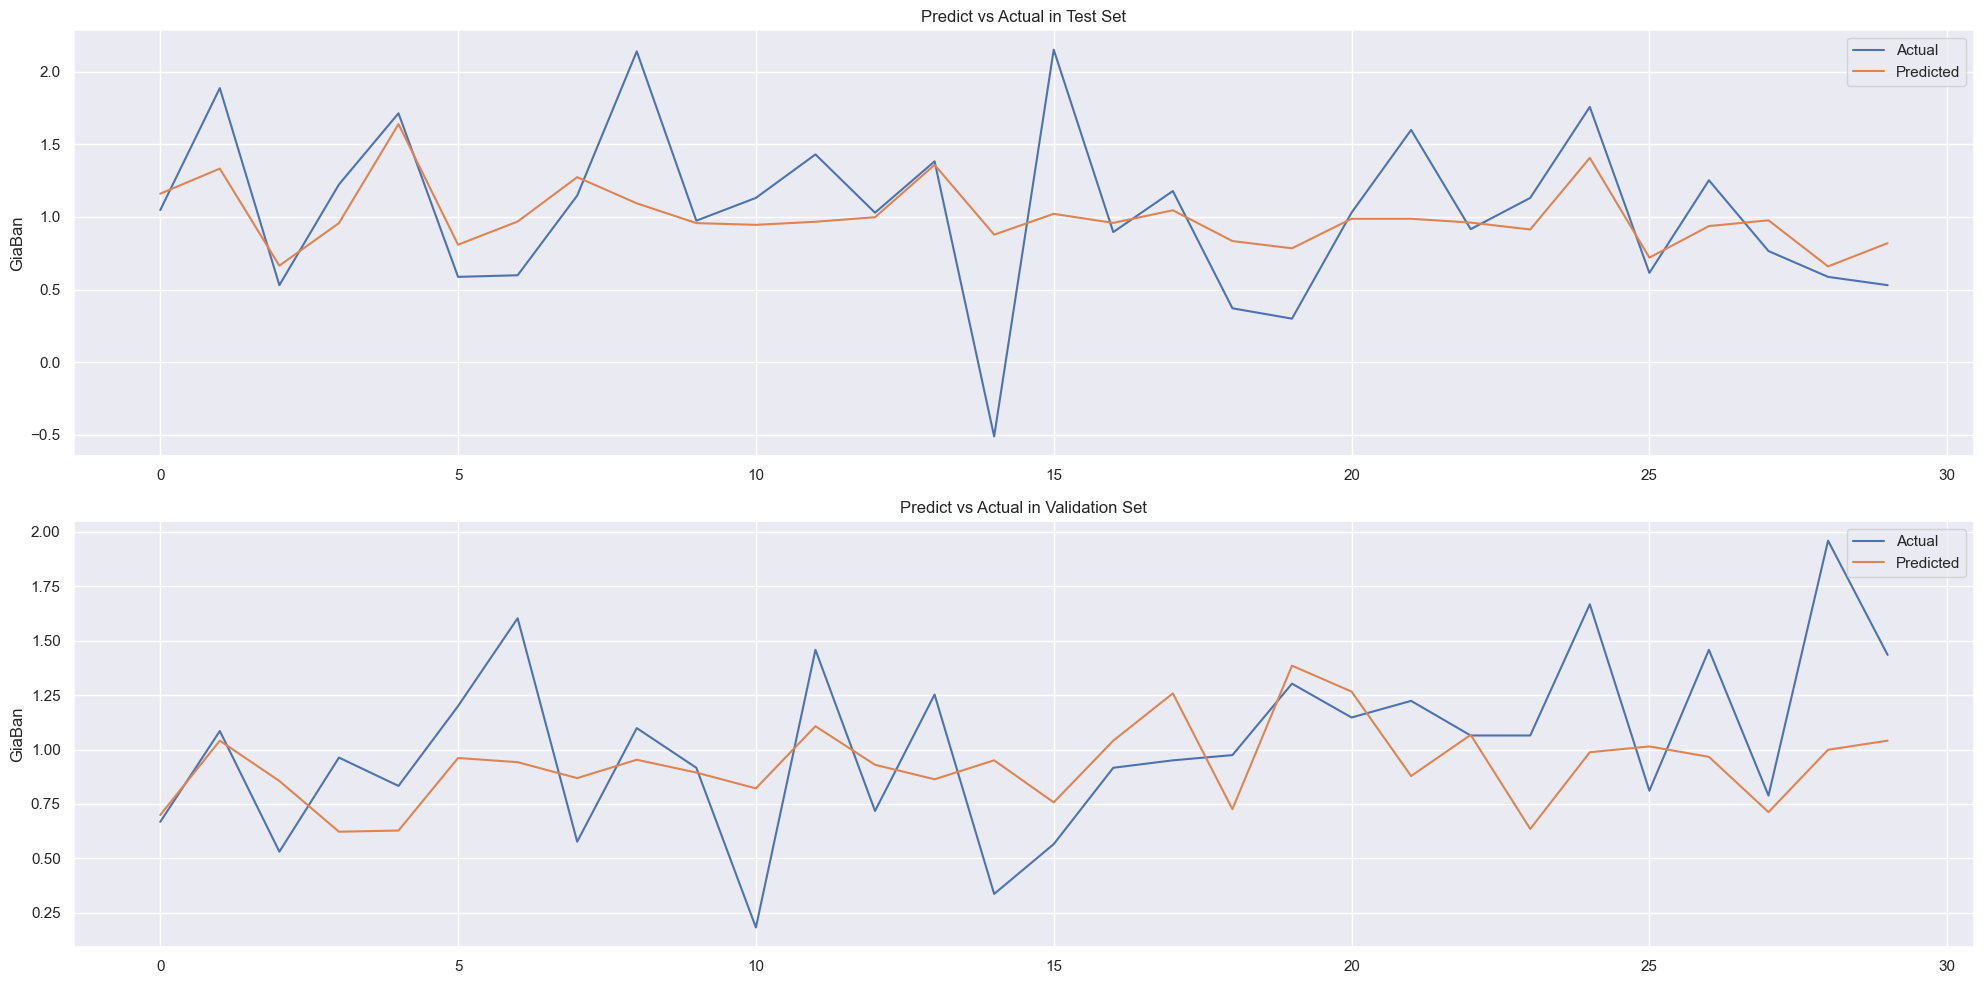

In [315]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))
axes[0].set_ylabel("GiaBan")
axes[0].set_title('Predict vs Actual in Test Set')
axes[0].plot(np.array(y_test_linear[:30]), label='Actual')
axes[0].plot(y_test_pred[:30], label='Predicted')
axes[0].legend()
axes[1].set_ylabel("GiaBan")
axes[1].set_title('Predict vs Actual in Validation Set')
axes[1].plot(np.array(y_val_linear[:30]), label='Actual')
axes[1].plot(y_val_pred[:30], label='Predicted')
axes[1].legend()
plt.tight_layout()
plt.show()

In [316]:
data = {'Metric': ['R2-score', 'MAE', 'MSE', 'RMSE'],
        'Before Optimization (Validation)': [r2_val_before, mae_val_before, mse_val_before, rmse_val_before],
        'After Optimization (Validation)': [r2_val_after, mae_val_after, mse_val_after, rmse_val_after],
        'Before Optimization (Test)': [r2_test_before, mae_test_before, mse_test_before, rmse_test_before],
        'After Optimization (Test)': [r2_test_after, mae_test_after, mse_test_after, rmse_test_after]}
print(tabulate(data, headers='keys', tablefmt='fancy_grid'))
print()

╒══════════╤════════════════════════════════════╤═══════════════════════════════════╤══════════════════════════════╤═════════════════════════════╕
│ Metric   │   Before Optimization (Validation) │   After Optimization (Validation) │   Before Optimization (Test) │   After Optimization (Test) │
╞══════════╪════════════════════════════════════╪═══════════════════════════════════╪══════════════════════════════╪═════════════════════════════╡
│ R2-score │                            0.25987 │                           0.25987 │                      0.36774 │                     0.36774 │
├──────────┼────────────────────────────────────┼───────────────────────────────────┼──────────────────────────────┼─────────────────────────────┤
│ MAE      │                            0.34935 │                           0.34935 │                      0.35688 │                     0.35688 │
├──────────┼────────────────────────────────────┼───────────────────────────────────┼──────────────────────────────┼──

### Sử dụng mô hình RandomForestRegressor

In [317]:
X_train_randomforest=X_train_b.copy()
X_test_randomforest=X_test_b.copy()
X_val_randomforest=X_val_b.copy()
y_train_randomforest=y_train_b.copy()
y_test_randomforest=y_test_b.copy()
y_val_randomforest=y_val_b.copy()

In [318]:
model = RandomForestRegressor(random_state = 20)
model.fit(X_train_randomforest, y_train_randomforest)
y_val_pred = model.predict(X_val_randomforest)
r2_val_before = r2_score(y_val_randomforest, y_val_pred).round(5)
y_test_pred = model.predict(X_test_randomforest)
r2_test_before = r2_score(y_test_randomforest, y_test_pred).round(5)
mae_val_before = mean_absolute_error(y_val_randomforest, y_val_pred).round(5)
mae_test_before = mean_absolute_error(y_test_randomforest, y_test_pred).round(5)
mse_val_before = mean_squared_error(y_val_randomforest,y_val_pred).round(5)
mse_test_before = mean_squared_error(y_test_randomforest,y_test_pred).round(5)
rmse_val_before= mean_squared_error(y_val_randomforest, y_val_pred, squared=False).round(5)
rmse_test_before= mean_squared_error(y_test_randomforest, y_test_pred, squared=False).round(5)
print("R2-score in validation: ", r2_val_before)
print("R2-score in test: ", r2_test_before)
print()
print("Test error (MAE) in validation: {}".format(mae_val_before))
print("Test error (MAE) in  test: {}".format(mae_test_before))
print()
print("Test error (MSE) in validation: {}".format(mse_val_before))
print("Test error (MSE) in test: {}".format(mse_test_before))
print()
print("Test error (RMSE) in validation: {}".format(rmse_val_before))
print("Test error (RMSE) in test: {}".format(rmse_test_before))
print
df = pd.DataFrame({'Giá trị nhãn đúng': y_val_randomforest, 'Nhãn dự đoán': y_val_pred, 'Chênh lệch': abs(y_val_randomforest - y_val_pred)})
print(df)

R2-score in validation:  0.36851
R2-score in test:  0.36377

Test error (MAE) in validation: 0.32741
Test error (MAE) in  test: 0.36121

Test error (MSE) in validation: 0.21181
Test error (MSE) in test: 0.24469

Test error (RMSE) in validation: 0.46023
Test error (RMSE) in test: 0.49466
      Giá trị nhãn đúng  Nhãn dự đoán  Chênh lệch
3048           0.667829      0.766713    0.098883
3591           1.085189      1.067661    0.017529
4967           0.530628      0.833599    0.302971
303            0.963174      0.822525    0.140649
7099           0.832909      0.782947    0.049962
...                 ...           ...         ...
2022           1.420696      1.511858    0.091162
2530           0.506818      0.932471    0.425654
4235           1.481605      0.752592    0.729013
4141           0.470004      0.485676    0.015672
7355           0.641854      0.766961    0.125107

[1634 rows x 3 columns]


#### Hiệu chỉnh mô hình

In [319]:
model = RandomForestRegressor(random_state=20)
param_grid = {
    'n_estimators': [50, 100, 200, 300],  # Số lượng cây trong Random Forest
    'max_depth': [None, 5, 10],  # Độ sâu tối đa của cây
    'min_samples_split': [2, 5, 10]  # Số lượng mẫu nhỏ nhất để chia
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=5)
grid_search.fit(X_train_randomforest, y_train_randomforest)
best_model = grid_search.best_estimator_
print("Best parameters: {}".format(grid_search.best_params_))

Best parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 300}


#### Truyền tham số tốt nhất để chạy trên tập test

In [320]:
model = RandomForestRegressor(max_depth = 5, min_samples_split = 2, n_estimators = 300,random_state=20)
model.fit(X_train_randomforest, y_train_randomforest)
y_val_pred = model.predict(X_val_randomforest)
r2_val_after = r2_score(y_val_randomforest, y_val_pred).round(5)
y_test_pred = model.predict(X_test_randomforest)
r2_test_after = r2_score(y_test_randomforest, y_test_pred).round(5)
mae_test_after = mean_absolute_error(y_test_randomforest,y_test_pred).round(5)
mae_val_after = mean_absolute_error(y_val_randomforest,y_val_pred).round(5)
mse_test_after = mean_squared_error(y_test_randomforest,y_test_pred).round(5)
mse_val_after = mean_squared_error(y_val_randomforest,y_val_pred).round(5)
rmse_test_after = mean_squared_error(y_test_randomforest,y_test_pred,squared = False).round(5)
rmse_val_after = mean_squared_error(y_val_randomforest,y_val_pred,squared = False).round(5)
print("R2-score trên tập validation:", r2_val_after)
print("R2-score trên tập test:", r2_test_after)
print()
print("Test error (MAE) in validation: {}".format(mae_val_after))
print("Test error (MAE) in test: {}".format(mae_test_after))
print()
print("Test error (MSE) in validation: {}".format(mse_val_after))
print("Test error (MSE) in test: {}".format(mse_test_after))
print()
print("Test error (RMSE) in validation: {}".format(rmse_val_after))
print("Test error (RMSE) in test: {}".format(rmse_test_after))
print()
df = pd.DataFrame({'Giá trị nhãn đúng': y_test_randomforest, 'Nhãn dự đoán': y_test_pred,'Chênh lệch': abs(y_test_randomforest-y_test_pred)})
print(df)

R2-score trên tập validation: 0.38756
R2-score trên tập test: 0.44343

Test error (MAE) in validation: 0.32211
Test error (MAE) in test: 0.33771

Test error (MSE) in validation: 0.20542
Test error (MSE) in test: 0.21406

Test error (RMSE) in validation: 0.45323
Test error (RMSE) in test: 0.46266

      Giá trị nhãn đúng  Nhãn dự đoán  Chênh lệch
7582           1.047319      1.134386    0.087067
1090           1.887070      1.953892    0.066823
6008           0.530628      0.698778    0.168149
3773           1.223775      1.160187    0.063588
6473           1.713798      1.192701    0.521097
...                 ...           ...         ...
668            0.500775      0.746947    0.246172
7535           0.614585      1.050705    0.436120
7124           0.693147      1.073346    0.380199
7474           0.765468      0.724000    0.041468
2762           0.974560      1.385816    0.411256

[1634 rows x 3 columns]


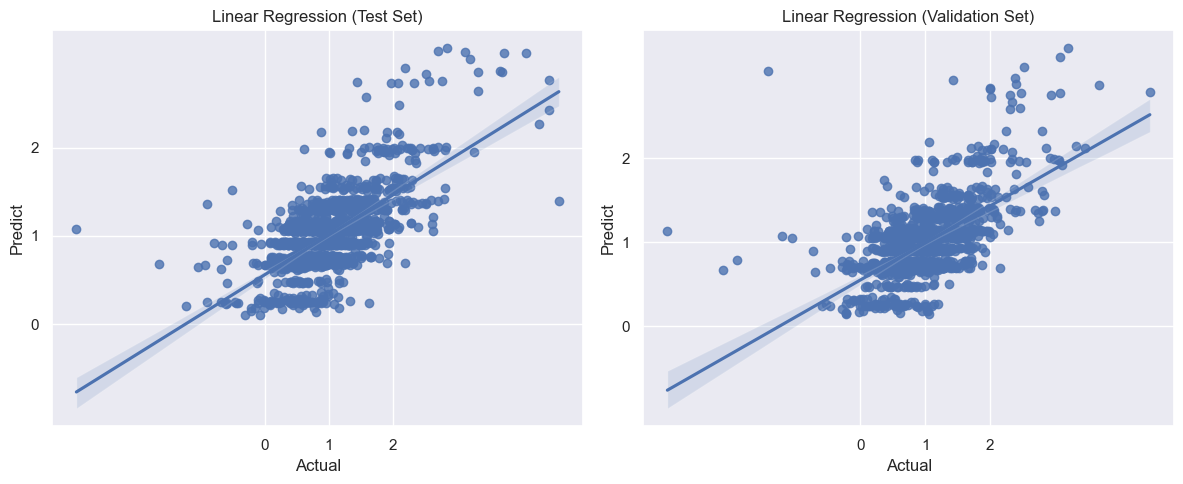

In [321]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ax1 = axes[0]
sns.regplot(x=y_test_randomforest, y=y_test_pred, ax=ax1)
ax1.set_title('Linear Regression (Test Set)')
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predict')
ax1.set_xticks(range(0, 3, 1))
ax1.set_yticks(range(0, 3, 1))
ax2 = axes[1]
sns.regplot(x=y_val_randomforest, y=y_val_pred, ax=ax2)
ax2.set_title('Linear Regression (Validation Set)')
ax2.set_xlabel('Actual')
ax2.set_ylabel('Predict')
ax2.set_xticks(range(0, 3, 1))
ax2.set_yticks(range(0, 3, 1))
plt.tight_layout()
plt.show()

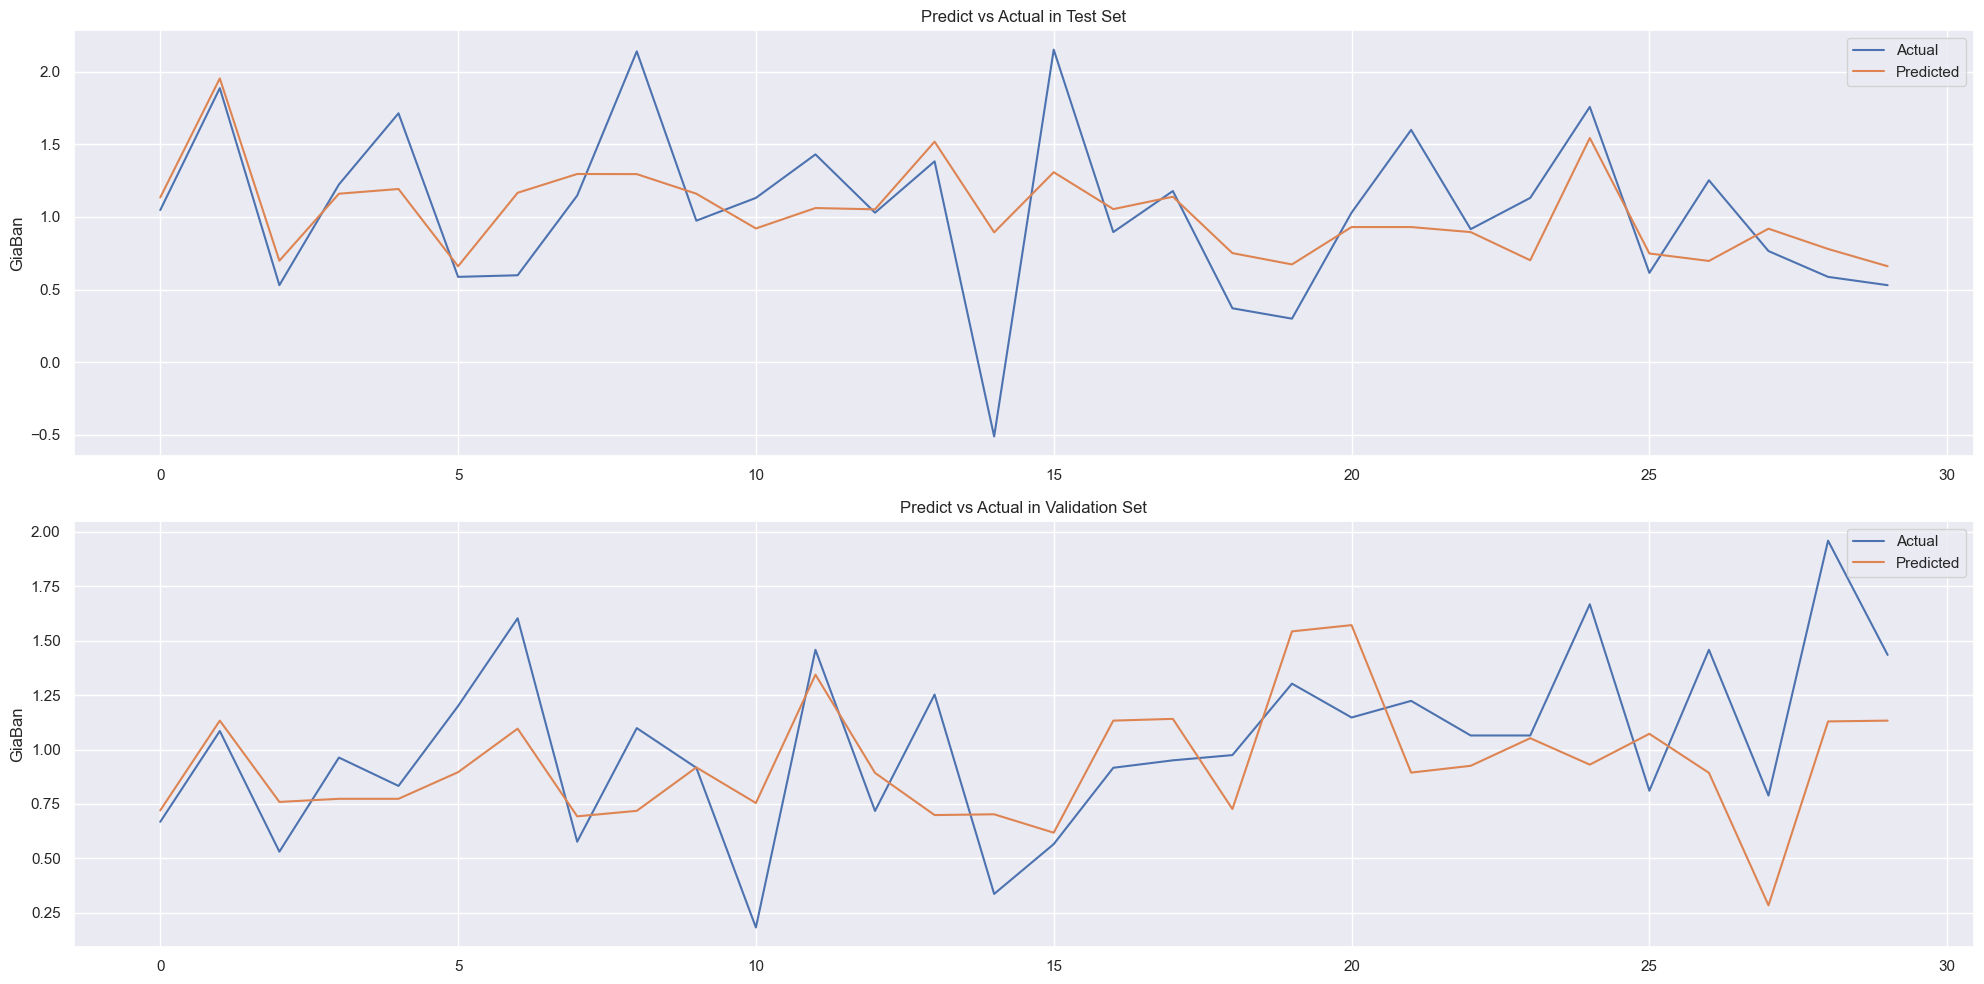

In [322]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))
axes[0].set_ylabel("GiaBan")
axes[0].set_title('Predict vs Actual in Test Set')
axes[0].plot(np.array(y_test_randomforest[:30]), label='Actual')
axes[0].plot(y_test_pred[:30], label='Predicted')
axes[0].legend()
axes[1].set_ylabel("GiaBan")
axes[1].set_title('Predict vs Actual in Validation Set')
axes[1].plot(np.array(y_val_randomforest[:30]), label='Actual')
axes[1].plot(y_val_pred[:30], label='Predicted')
axes[1].legend()
plt.tight_layout()
plt.show()


In [323]:
data = {'Metric': ['R2-score', 'MAE', 'MSE', 'RMSE'],
        'Before Optimization (Validation)': [r2_val_before, mae_val_before, mse_val_before, rmse_val_before],
        'After Optimization (Validation)': [r2_val_after, mae_val_after, mse_val_after, rmse_val_after],
        'Before Optimization (Test)': [r2_test_before, mae_test_before, mse_test_before, rmse_test_before],
        'After Optimization (Test)': [r2_test_after, mae_test_after, mse_test_after, rmse_test_after]}
print(tabulate(data, headers='keys', tablefmt='fancy_grid'))
print()

╒══════════╤════════════════════════════════════╤═══════════════════════════════════╤══════════════════════════════╤═════════════════════════════╕
│ Metric   │   Before Optimization (Validation) │   After Optimization (Validation) │   Before Optimization (Test) │   After Optimization (Test) │
╞══════════╪════════════════════════════════════╪═══════════════════════════════════╪══════════════════════════════╪═════════════════════════════╡
│ R2-score │                            0.36851 │                           0.38756 │                      0.36377 │                     0.44343 │
├──────────┼────────────────────────────────────┼───────────────────────────────────┼──────────────────────────────┼─────────────────────────────┤
│ MAE      │                            0.32741 │                           0.32211 │                      0.36121 │                     0.33771 │
├──────────┼────────────────────────────────────┼───────────────────────────────────┼──────────────────────────────┼──

### Sử dụng mô hình GradientBoostingRegressor

In [324]:
X_train_boot = X_train_b.copy()
X_test_boot = X_test_b.copy()
X_val_boot = X_val_b.copy()
y_train_boot = y_train_b.copy()
y_test_boot = y_test_b.copy()
y_val_boot = y_val_b.copy()

In [325]:
model = GradientBoostingRegressor(random_state = 20)
model.fit(X_train_boot, y_train_boot)
y_val_pred = model.predict(X_val_boot)
r2_val_before = r2_score(y_val_boot, y_val_pred).round(5)
y_test_pred = model.predict(X_test_boot)
r2_test_before = r2_score(y_test_boot, y_test_pred).round(5)
mae_val_before = mean_absolute_error(y_val_boot, y_val_pred).round(5)
mae_test_before = mean_absolute_error(y_test_boot, y_test_pred).round(5)
mse_val_before = mean_squared_error(y_val_boot,y_val_pred).round(5)
mse_test_before = mean_squared_error(y_test_boot,y_test_pred).round(5)
rmse_val_before= mean_squared_error(y_val_boot, y_val_pred, squared=False).round(5)
rmse_test_before= mean_squared_error(y_test_boot, y_test_pred, squared=False).round(5)
print("R2-score in validation: ", r2_val_before)
print("R2-score in test: ", r2_test_before)
print()
print("Test error (MAE) in validation: {}".format(mae_val_before))
print("Test error (MAE) in  test: {}".format(mae_test_before))
print()
print("Test error (MSE) in validation: {}".format(mse_val_before))
print("Test error (MSE) in test: {}".format(mse_test_before))
print()
print("Test error (RMSE) in validation: {}".format(rmse_val_before))
print("Test error (RMSE) in test: {}".format(rmse_test_before))
print
df = pd.DataFrame({'Giá trị nhãn đúng': y_val_boot, 'Nhãn dự đoán': y_val_pred, 'Chênh lệch': abs(y_val_boot - y_val_pred)})
print(df)


R2-score in validation:  0.40118
R2-score in test:  0.43803

Test error (MAE) in validation: 0.31809
Test error (MAE) in  test: 0.33947

Test error (MSE) in validation: 0.20085
Test error (MSE) in test: 0.21613

Test error (RMSE) in validation: 0.44816
Test error (RMSE) in test: 0.4649
      Giá trị nhãn đúng  Nhãn dự đoán  Chênh lệch
3048           0.667829      0.652636    0.015193
3591           1.085189      1.158888    0.073699
4967           0.530628      0.780364    0.249736
303            0.963174      0.818112    0.145063
7099           0.832909      0.818112    0.014797
...                 ...           ...         ...
2022           1.420696      1.280938    0.139758
2530           0.506818      0.707983    0.201165
4235           1.481605      0.705551    0.776053
4141           0.470004      0.287145    0.182859
7355           0.641854      0.680726    0.038873

[1634 rows x 3 columns]


## Hiệu Chỉnh mô hình

In [326]:
model = GradientBoostingRegressor(random_state=20)
param_grid = {
    'n_estimators': [50, 100, 200, 300], 
    'learning_rate': [0.05, 0.1, 0.2],  
    'max_depth': [3, 4, 5, 6]  
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=5)
grid_search.fit(X_train_boot, y_train_boot)
best_model = grid_search.best_estimator_
print("Best parameters: {}".format(grid_search.best_params_))

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


In [327]:
model = GradientBoostingRegressor(n_estimators = 50, max_depth = 3, learning_rate= 0.1,random_state=20)
model.fit(X_train_boot, y_train_boot)
y_val_pred = model.predict(X_val_boot)
r2_val_after = r2_score(y_val_boot, y_val_pred).round(5)
y_test_pred = model.predict(X_test_boot)
r2_test_after= r2_score(y_test_boot, y_test_pred).round(5)
mae_test_after = mean_absolute_error(y_test_boot,y_test_pred).round(5)
mae_val_after = mean_absolute_error(y_val_boot,y_val_pred).round(5)
mse_test_after = mean_squared_error(y_test_boot,y_test_pred).round(5)
mse_val_after = mean_squared_error(y_val_boot,y_val_pred).round(5)
rmse_test_after = mean_squared_error(y_test_boot,y_test_pred,squared = False).round(5)
rmse_val_after = mean_squared_error(y_val_boot,y_val_pred,squared = False).round(5)
print("R2-score trên tập validation:", r2_val_after)
print("R2-score trên tập test:", r2_test_after)
print()
print("Test error (MAE) in validation: {}".format(mae_val_after))
print("Test error (MAE) in test: {}".format(mae_test_after))
print()
print("Test error (MSE) in validation: {}".format(mse_val_after))
print("Test error (MSE) in test: {}".format(mse_test_after))
print()
print("Test error (RMSE) in validation: {}".format(rmse_val_after))
print("Test error (RMSE) in test: {}".format(rmse_test_after))
print()
df = pd.DataFrame({'Giá trị nhãn đúng': y_test_boot, 'Nhãn dự đoán': y_test_pred,'Chênh lệch': abs(y_test_boot-y_test_pred)})
print(df)

R2-score trên tập validation: 0.39386
R2-score trên tập test: 0.43908

Test error (MAE) in validation: 0.31987
Test error (MAE) in test: 0.33877

Test error (MSE) in validation: 0.20331
Test error (MSE) in test: 0.21573

Test error (RMSE) in validation: 0.4509
Test error (RMSE) in test: 0.46447

      Giá trị nhãn đúng  Nhãn dự đoán  Chênh lệch
7582           1.047319      1.123391    0.076072
1090           1.887070      1.821871    0.065199
6008           0.530628      0.752756    0.222128
3773           1.223775      1.180308    0.043468
6473           1.713798      1.487470    0.226328
...                 ...           ...         ...
668            0.500775      0.723483    0.222708
7535           0.614585      1.016320    0.401735
7124           0.693147      1.047299    0.354152
7474           0.765468      0.777549    0.012081
2762           0.974560      1.409315    0.434755

[1634 rows x 3 columns]


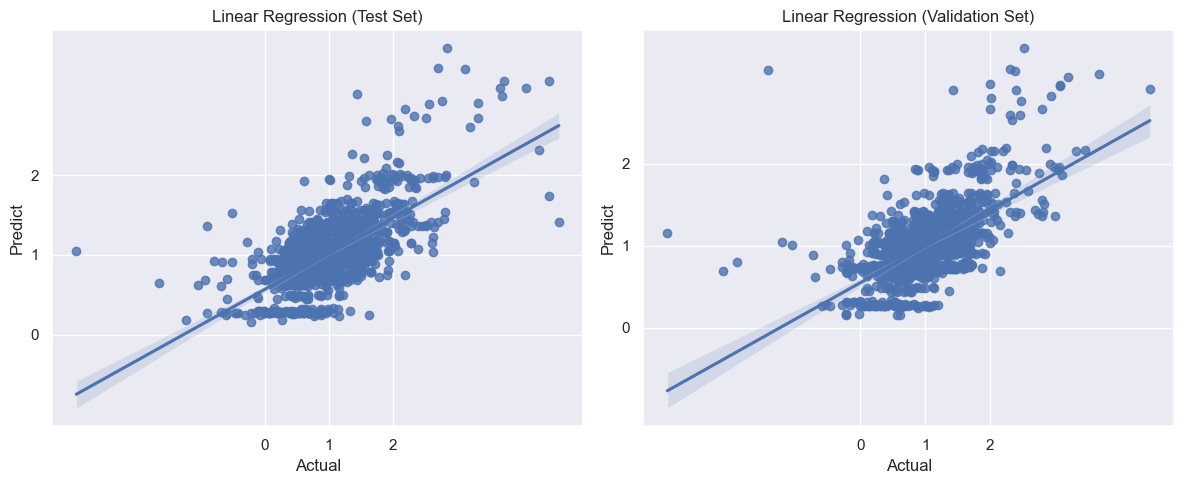

In [328]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ax1 = axes[0]
sns.regplot(x=y_test_boot, y=y_test_pred, ax=ax1)
ax1.set_title('Linear Regression (Test Set)')
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predict')
ax1.set_xticks(range(0, 3, 1))
ax1.set_yticks(range(0, 3, 1))
ax2 = axes[1]
sns.regplot(x=y_val_boot, y=y_val_pred, ax=ax2)
ax2.set_title('Linear Regression (Validation Set)')
ax2.set_xlabel('Actual')
ax2.set_ylabel('Predict')
ax2.set_xticks(range(0, 3, 1))
ax2.set_yticks(range(0, 3, 1))
plt.tight_layout()
plt.show()

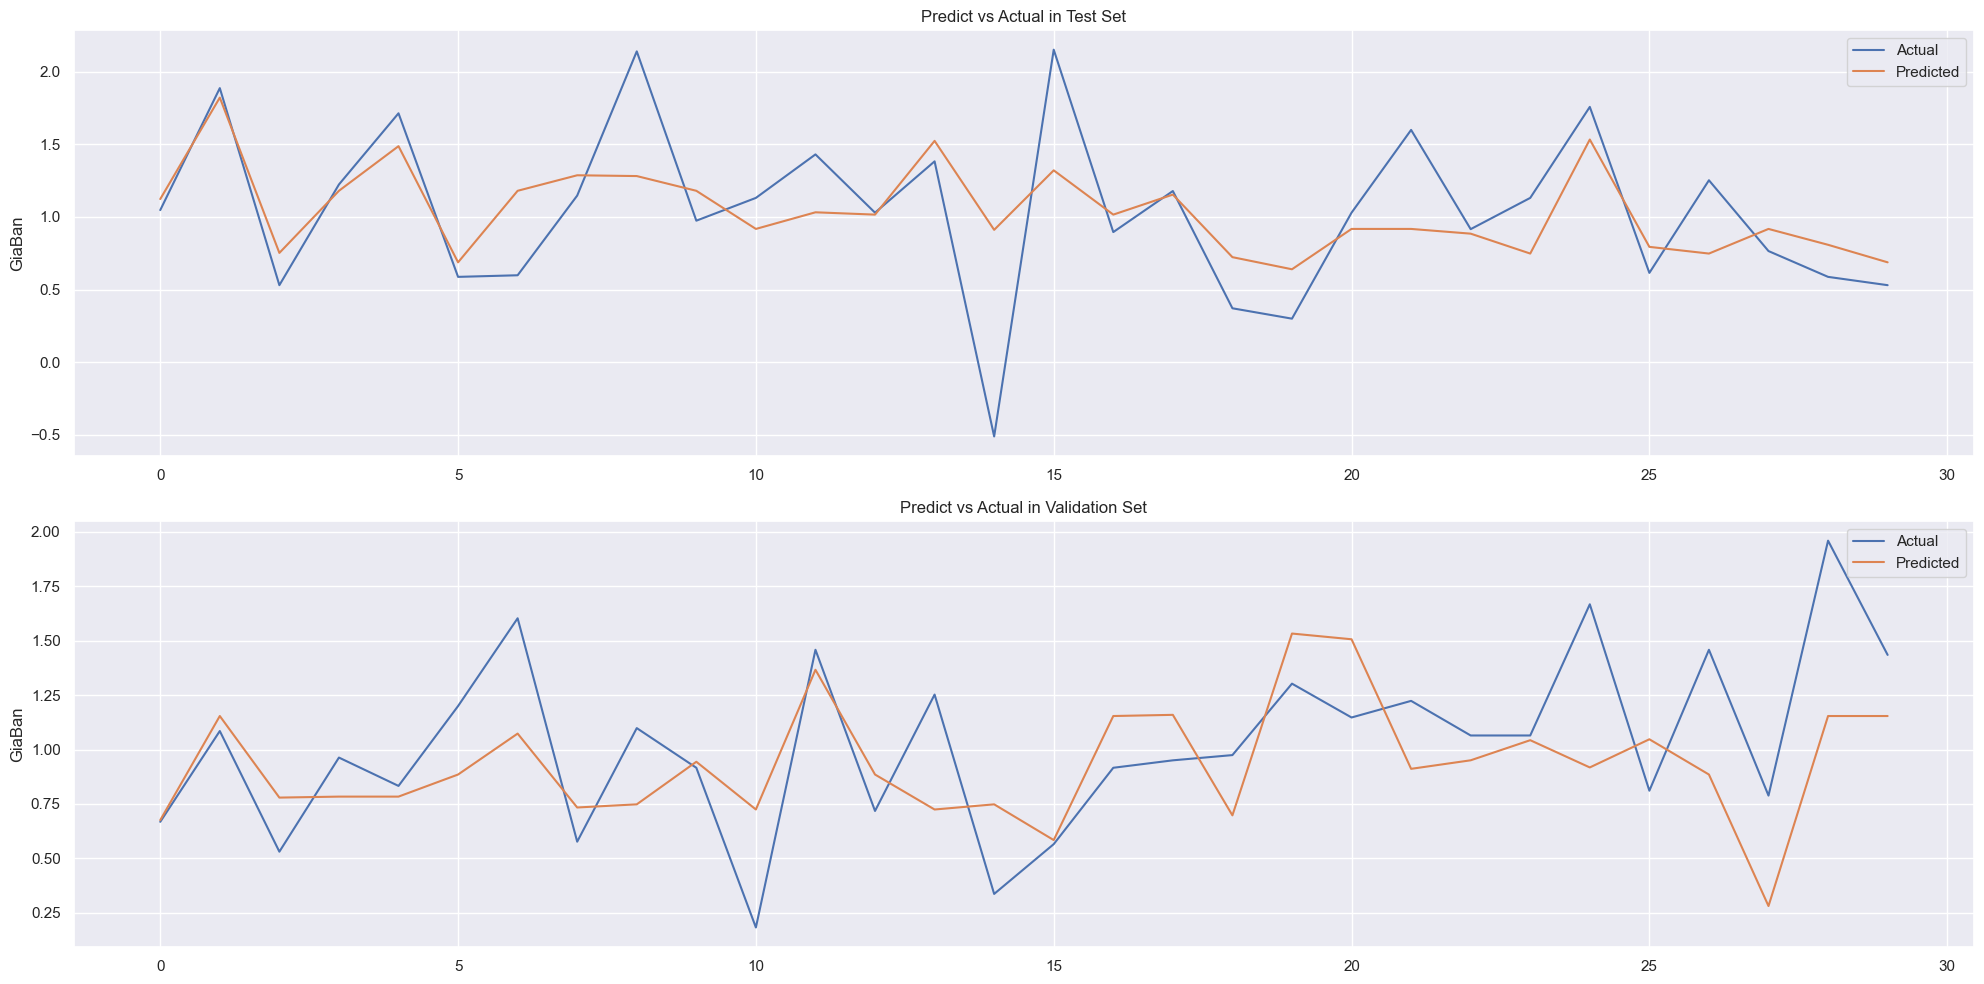

In [329]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))
axes[0].set_ylabel("GiaBan")
axes[0].set_title('Predict vs Actual in Test Set')
axes[0].plot(np.array(y_test_boot[:30]), label='Actual')
axes[0].plot(y_test_pred[:30], label='Predicted')
axes[0].legend()

# Biểu đồ cho tập validation
axes[1].set_ylabel("GiaBan")
axes[1].set_title('Predict vs Actual in Validation Set')
axes[1].plot(np.array(y_val_boot[:30]), label='Actual')
axes[1].plot(y_val_pred[:30], label='Predicted')
axes[1].legend()

plt.tight_layout()
plt.show()


In [330]:
data = {'Metric': ['R2-score', 'MAE', 'MSE', 'RMSE'],
        'Before Optimization (Validation)': [r2_val_before, mae_val_before, mse_val_before, rmse_val_before],
        'After Optimization (Validation)': [r2_val_after, mae_val_after, mse_val_after, rmse_val_after],
        'Before Optimization (Test)': [r2_test_before, mae_test_before, mse_test_before, rmse_test_before],
        'After Optimization (Test)': [r2_test_after, mae_test_after, mse_test_after, rmse_test_after]}
print(tabulate(data, headers='keys', tablefmt='fancy_grid'))
print()

╒══════════╤════════════════════════════════════╤═══════════════════════════════════╤══════════════════════════════╤═════════════════════════════╕
│ Metric   │   Before Optimization (Validation) │   After Optimization (Validation) │   Before Optimization (Test) │   After Optimization (Test) │
╞══════════╪════════════════════════════════════╪═══════════════════════════════════╪══════════════════════════════╪═════════════════════════════╡
│ R2-score │                            0.40118 │                           0.39386 │                      0.43803 │                     0.43908 │
├──────────┼────────────────────────────────────┼───────────────────────────────────┼──────────────────────────────┼─────────────────────────────┤
│ MAE      │                            0.31809 │                           0.31987 │                      0.33947 │                     0.33877 │
├──────────┼────────────────────────────────────┼───────────────────────────────────┼──────────────────────────────┼──

In [331]:
linear_pipeline = Pipeline([
    ('linear', LinearRegression())  
])
randomforest_pipeline = Pipeline([
    ('randomforest', RandomForestRegressor(max_depth = 5, min_samples_split = 2, n_estimators = 300,random_state=20))  # Mô hình Random Forest Regression
])
gradientboost_pipeline = Pipeline([
    ('gradientboost', GradientBoostingRegressor(n_estimators=50, max_depth=3, learning_rate=0.1, random_state=20))  # Mô hình Gradient Boosting Regression
])
stacked_model = StackingRegressor(
    estimators=[('linear', linear_pipeline), ('randomforest', randomforest_pipeline), ('gradientboost', gradientboost_pipeline)]
)
stacked_model.fit(X_train_b, y_train_b)
y_val_pred_stacked = stacked_model.predict(X_val_b)
r2_val_btacked = r2_score(y_val_b, y_val_pred_stacked)
mse_val_btacked = mean_squared_error(y_val_b, y_val_pred_stacked)
mae_val_btacked = mean_absolute_error(y_val_b, y_val_pred_stacked)
y_test_pred_stacked = stacked_model.predict(X_test_b)
r2_test_btacked = r2_score(y_test_b, y_test_pred_stacked)
mse_test_btacked = mean_squared_error(y_test_b, y_test_pred_stacked)
mae_test_btacked = mean_absolute_error(y_test_b, y_test_pred_stacked)
print("R2-score on validation set (Stacked Model):", r2_val_btacked)
print("MSE on validation set (Stacked Model):", mse_val_btacked)
print("MAE on validation set (Stacked Model):", mae_val_btacked)
print()
print("R2-score on test set (Stacked Model):", r2_test_btacked)
print("MSE on test set (Stacked Model):", mse_test_btacked)
print("MAE on test set (Stacked Model):", mae_test_btacked)

R2-score on validation set (Stacked Model): 0.3906068702801808
MSE on validation set (Stacked Model): 0.20439883889317245
MAE on validation set (Stacked Model): 0.32039907621312746

R2-score on test set (Stacked Model): 0.43961267306323226
MSE on test set (Stacked Model): 0.21552466360010455
MAE on test set (Stacked Model): 0.33872815446050697
